In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from scipy.stats import poisson, binom, nbinom, lognorm, pareto, gamma
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [2]:
# Load the claims data file into a DataFrame 
file_path = "claim_data_group4_2024.csv"
claims_data = pd.read_csv(file_path)

# Descriptive Statistics

In [17]:
def plot_variable(data, group_var, ax_freq, ax_sev):
    """
    Function to plot frequency and severity of claims by policyholder characteristics.
    
    :param data: DataFrame to plot.
    :param group_var: The variable to group by.
    :param ax_freq: The axes object for frequency plots.
    :param ax_sev: The axes object for severity plots.
    """
    # Calculate frequency and severity
    freq = data.groupby(group_var)['ClaimNb'].sum()
    sev = data[data['ClaimNb'] > 0].groupby(group_var)['ClaimAmount'].mean()
    
    dollar_formatter = FuncFormatter(lambda x, pos: f'${int(x)}')

    # Plot Frequency
    sns.barplot(x=freq.index, y=freq.values, ax=ax_freq)
    ax_freq.set_title(f'Claim Frequency by {group_var}')
    ax_freq.set_xlabel(group_var)
    ax_freq.set_ylabel('Total Claims')
    ax_freq.tick_params(axis='x')
    if group_var in ['BonusMalus','DrivAge', 'VehAge']:
        ax_freq.xaxis.set_major_locator(MaxNLocator(10))

    # Plot Severity
    sns.barplot(x=sev.index, y=sev.values, ax=ax_sev)
    ax_sev.set_title(f'Claim Severity by {group_var}')
    ax_sev.set_xlabel(group_var)
    ax_sev.set_ylabel('Average Claim Amount')
    ax_sev.tick_params(axis='x')
    ax_sev.yaxis.set_major_formatter(dollar_formatter)
    if group_var in ['BonusMalus', 'DrivAge']:
        ax_sev.xaxis.set_major_locator(MaxNLocator(10))

In [3]:
# Add frequency column
# Assuming your DataFrame is named 'claims_data' and the relevant columns are 'ClaimCount' and 'Exposure'
claims_data['Frequency'] = claims_data['ClaimNb'] / claims_data['Exposure']

# Check the updated DataFrame
claims_data[['Frequency']].max()


Frequency    365.000004
dtype: float64

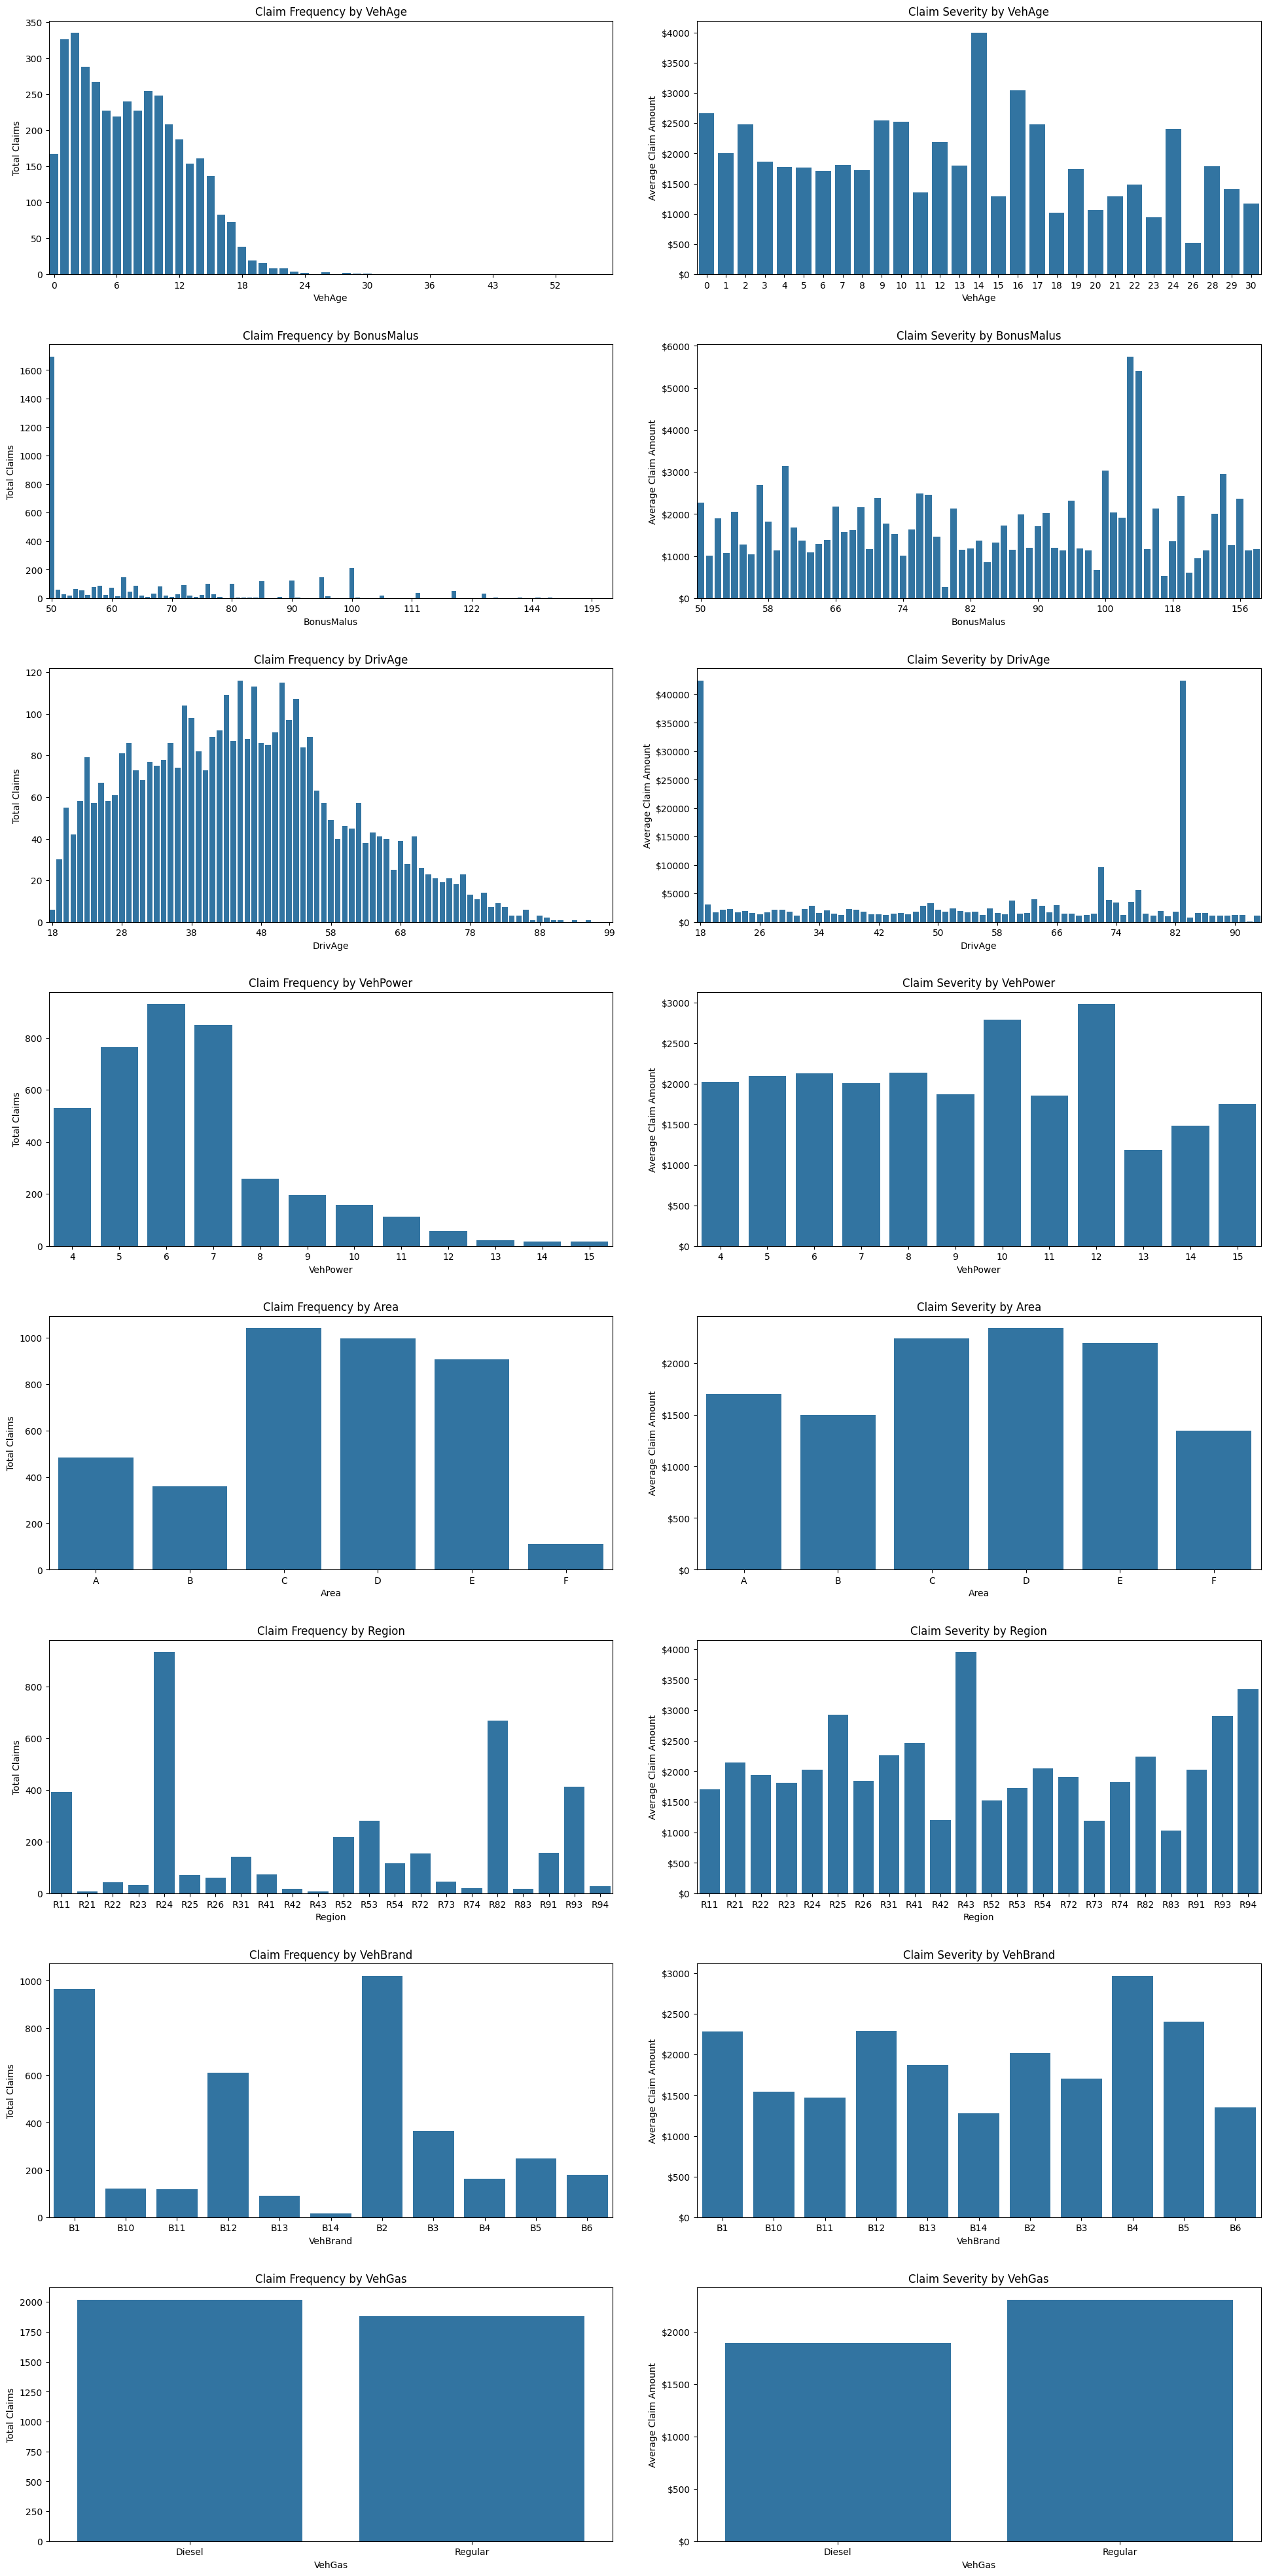

In [18]:
# Variables to plot frequency and severity of claims by policyholder characteristics
variables = ['VehAge', 'BonusMalus', 'DrivAge', 'VehPower', 'Area','Region', 'VehBrand', 'VehGas']

fig, axes = plt.subplots(nrows=len(variables), ncols=2, figsize=(20, 5 * len(variables))) 

# Loop through each variable and apply the plotting function on subplots
for idx, var in enumerate(variables):
    plot_variable(claims_data, var, axes[idx, 0], axes[idx, 1])

plt.tight_layout(pad=3.0) 
plt.show()

In [19]:
# Get descriptive statistics from the claims data set 
descriptive_stats = claims_data.describe()
descriptive_stats

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,2.617735e+06,0.039020,0.528057,6.460230,6.992550,45.483040,59.822980,1800.69569,76.599887
std,1.643394e+06,0.206296,0.364232,2.055641,5.637297,14.154698,15.652541,3955.08311,1531.841302
min,1.500000e+01,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,2.00000,0.000000
25%,1.156127e+06,0.000000,0.170000,5.000000,2.000000,34.000000,50.000000,94.00000,0.000000
50%,2.271008e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,399.00000,0.000000
75%,4.044791e+06,0.000000,0.990000,7.000000,11.000000,55.000000,65.000000,1658.00000,0.000000
max,6.114324e+06,4.000000,1.000000,15.000000,100.000000,99.000000,230.000000,27000.00000,200000.000000


In [20]:
total_claims_frequency = pd.DataFrame(claims_data['ClaimNb'].value_counts())
total_claims_frequency

,count
ClaimNb,
0,96335
1,3441
2,214
3,7
4,3


In [70]:
total_claims_severity = pd.DataFrame(claims_data['Frequency'].value_counts())
total_claims_severity

,count
Frequency,
0.000000,96335
1.000000,1247
2.000000,146
2.040816,59
4.166667,53
...,...
22.222222,1
2.597403,1
121.666668,1


In [22]:
# Total claims by driver's age 
total_claims_by_age_frequency = claims_data.groupby('DrivAge')['ClaimNb'].sum()
total_claims_by_age_severity = claims_data.groupby('DrivAge')['ClaimAmount'].sum()
total_claims_by_age_frequency = pd.DataFrame(total_claims_by_age_frequency)
total_claims_by_age_severity = pd.DataFrame(total_claims_by_age_severity)
pd.concat([total_claims_by_age_frequency, total_claims_by_age_severity], axis=1)

,ClaimNb,ClaimAmount
DrivAge,,
18,6,211932.67
19,30,82079.72
20,55,91491.80
21,42,87797.24
22,58,113956.44
...,...,...
94,0,0.00
95,1,1172.00
96,0,0.00


In [23]:
# Total claims by vehicle's age 
total_claims_by_vech_age_frequency = claims_data.groupby('VehAge')['ClaimNb'].sum()
total_claims_by_vech_age_severity = claims_data.groupby('VehAge')['ClaimAmount'].sum()
total_claims_by_vech_age_frequency = pd.DataFrame(total_claims_by_vech_age_frequency)
total_claims_by_vech_age_severity = pd.DataFrame(total_claims_by_vech_age_severity)
pd.concat([total_claims_by_vech_age_frequency, total_claims_by_vech_age_severity], axis=1)

,ClaimNb,ClaimAmount
VehAge,,
0,167,410632.54
1,326,605801.74
2,335,776033.31
3,288,508193.74
4,267,441865.37
5,227,384044.79
6,219,351768.86
7,240,395305.52
8,227,378182.60


In [24]:
# Total claims by Bonus/Malus 
total_claims_by_bonus_malus_frequency = claims_data.groupby('BonusMalus')['ClaimNb'].sum()
total_claims_by_bonus_malus_severity = claims_data.groupby('BonusMalus')['ClaimAmount'].sum()
total_claims_by_vech_age_frequency = pd.DataFrame(total_claims_by_bonus_malus_frequency)
total_claims_by_bonus_malus_severity = pd.DataFrame(total_claims_by_bonus_malus_severity)
pd.concat([total_claims_by_bonus_malus_frequency, total_claims_by_bonus_malus_severity], axis=1)

,ClaimNb,ClaimAmount
BonusMalus,,
50,1694,3650556.48
51,59,57993.15
52,28,51447.90
53,18,19397.49
54,63,125119.17
...,...,...
190,0,0.00
195,0,0.00
196,0,0.00


In [25]:
# Total claims by vechicle's power 
total_claims_by_vech_power_frequency = claims_data.groupby('VehPower')['ClaimNb'].sum()
total_claims_by_vech_power_severity = claims_data.groupby('VehPower')['ClaimAmount'].sum()
total_claims_by_vech_power_frequency = pd.DataFrame(total_claims_by_vech_power_frequency)
total_claims_by_vech_power_severity = pd.DataFrame(total_claims_by_vech_power_severity)
pd.concat([total_claims_by_vech_power_frequency, total_claims_by_vech_power_severity], axis=1)

,ClaimNb,ClaimAmount
VehPower,,
4,529,994335.45
5,764,1523507.54
6,929,1862209.18
7,849,1591878.39
8,257,518985.02
9,194,340514.78
10,157,407308.33
11,112,191014.30
12,57,158011.39


# Cluster

*Catégorisation des variables*

In [5]:
# Function to perform quantile binning 
def quantile_binning_and_apply(claims_data, features, n_bins):
    bin_labels_dict = {}
    for feature in features:
        bin_edges = pd.qcut(claims_data[feature], q=n_bins, retbins=True, duplicates='drop')[1]
        bin_edges[-1] += 1e-5
        labels = [f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(len(bin_edges)-1)]
        claims_data[f'Binned {feature}'] = pd.cut(claims_data[feature], bins=bin_edges, labels=labels, include_lowest=True, duplicates='drop')
        bin_labels_dict[f'Binned {feature}'] = labels
        print(f'Labels for {feature}: {labels}')
    return bin_labels_dict

# Treatment of BonusMalus
claims_data['Binned BonusMalus'] = claims_data['BonusMalus'].apply(lambda x: 'Bonus' if x <= 100 else 'Malus')

In [6]:
# List of features to bin 
features = ['DrivAge', 'VehAge','VehPower']
n_bins = 10

# Call the function
bin_labels_dict = quantile_binning_and_apply(claims_data, features, n_bins)

Labels for DrivAge: ['18.0-28.0', '28.0-32.0', '32.0-36.0', '36.0-40.0', '40.0-44.0', '44.0-48.0', '48.0-53.0', '53.0-57.0', '57.0-65.0', '65.0-99.0']
Labels for VehAge: ['0.0-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', '4.0-6.0', '6.0-8.0', '8.0-10.0', '10.0-12.0', '12.0-15.0', '15.0-100.0']
Labels for VehPower: ['4.0-5.0', '5.0-6.0', '6.0-7.0', '7.0-8.0', '8.0-9.0', '9.0-15.0']


In [29]:
# Stop the code from running further
raise SystemExit("Stopping execution here.")

SystemExit: Stopping execution here.

C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


*Determining the optimal amount of clusters*

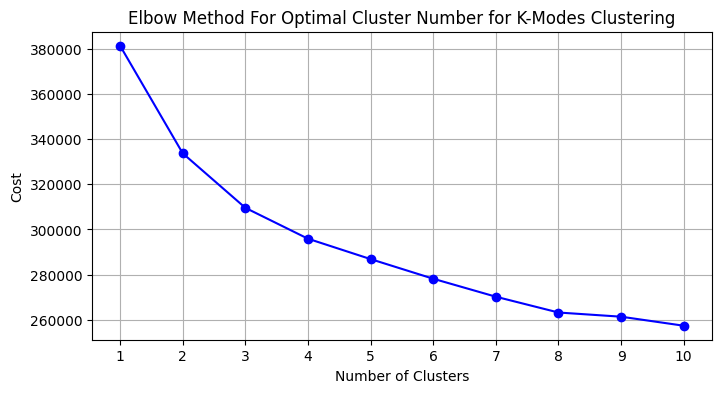

In [8]:
# Additional categorical columns
additional_categorical_columns = ['Area', 'VehBrand', 'Binned BonusMalus']

# Prepare data for one-hot encoding
categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns
for col in categorical_columns:
    claims_data[col] = claims_data[col].astype('category')

# Use only categorical columns for clustering 
df_categorical = claims_data[categorical_columns]

# Convert the DataFrame to a numpy array before applying K-Modes 
data_matrix = df_categorical.to_numpy()

# Apply the elbow method to find the optimal number of clusters for K-Modes clustering method
cost = []
K = range(1, 11)  # Range of clusters to try
for num_clusters in K:
    kmodes = KModes(n_clusters=num_clusters, random_state=42)
    clusters = kmodes.fit_predict(data_matrix)
    cost.append(kmodes.cost_)

# Plot the elbow graph
plt.figure(figsize=(8, 4))
plt.plot(K, cost, marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal Cluster Number for K-Modes Clustering')
plt.xticks(K)
plt.grid(True)
plt.show()

# Optimal amount of clusters = 3 

*Creating the clusters using K-Modes Clustering Method*

In [9]:
# Additional categorical columns
additional_categorical_columns = ['Area', 'VehBrand'] # See if we add more columns to improve the clustering results 

# Prepare data for one-hot encoding
# Combine binned features and additional categorical columns
categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns

# Convert categorical columns to category type
for col in categorical_columns:
    claims_data[col] = claims_data[col].astype('category')

# Use only categorical columns for clustering
df_categorical = claims_data[categorical_columns]

# Use only categorical columns for clustering
df_categorical = claims_data[categorical_columns]

# Convert the DataFrame to a numpy array
data_matrix = df_categorical.to_numpy()

# Apply K-Modes clustering with the optimal number of clusters 
kmodes = KModes(n_clusters=3, random_state=42)

# Fit the model to the data
clusters = kmodes.fit_predict(data_matrix)

# tore the result in 'Risk Cluster' column 
claims_data['Risk Cluster'] = clusters

# Analyze the clusters 
# Count how many data points belong to each cluster
print(claims_data['Risk Cluster'].value_counts())

# Analyser les caractéristiques de chaque cluster K-Modes
for cluster in range(kmodes.n_clusters):
    cluster_data = claims_data[claims_data['Risk Cluster'] == cluster]
    print(f"Cluster {cluster} characteristics:")
    print(cluster_data.describe(include='all'))
    print("\n")

Risk Cluster
0    56013
1    26546
2    17441
Name: count, dtype: int64
Cluster 0 characteristics:
               IDpol       ClaimNb      Exposure   Area      VehPower  \
count   5.601300e+04  56013.000000  56013.000000  56013  56013.000000   
unique           NaN           NaN           NaN      6           NaN   
top              NaN           NaN           NaN      C           NaN   
freq             NaN           NaN           NaN  22654           NaN   
mean    2.862297e+06      0.033814      0.503357    NaN      6.263314   
std     1.735630e+06      0.192795      0.357115    NaN      2.321863   
min     3.000000e+01      0.000000      0.002732    NaN      4.000000   
25%     1.189240e+06      0.000000      0.160000    NaN      4.000000   
50%     3.027692e+06      0.000000      0.460000    NaN      5.000000   
75%     4.128232e+06      0.000000      0.880000    NaN      7.000000   
max     6.114324e+06      4.000000      1.000000    NaN     15.000000   

              VehAge    

In [10]:
# Create DataFrames based on clusters
df_cluster_0 = claims_data[claims_data['Risk Cluster'] == 0].copy()
df_cluster_1 = claims_data[claims_data['Risk Cluster'] == 1].copy()
df_cluster_2 = claims_data[claims_data['Risk Cluster'] == 2].copy()
df_cluster_0

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Frequency,Binned BonusMalus,Binned DrivAge,Binned VehAge,Binned VehPower,Risk Cluster
0,2271893,0,0.83,E,5,17,53,64,B2,Diesel,3317,R93,0.0,0.0,Bonus,48.0-53.0,15.0-100.0,4.0-5.0,0
1,1111864,0,0.24,E,5,2,27,64,B3,Diesel,2740,R22,0.0,0.0,Bonus,18.0-28.0,1.0-2.0,4.0-5.0,0
6,1029431,0,0.18,C,12,1,50,50,B12,Diesel,490,R52,0.0,0.0,Bonus,48.0-53.0,0.0-1.0,9.0-15.0,0
9,2223998,0,0.08,C,5,4,56,50,B6,Regular,453,R72,0.0,0.0,Bonus,53.0-57.0,3.0-4.0,4.0-5.0,0
10,2053719,0,0.78,C,6,11,39,68,B6,Diesel,399,R24,0.0,0.0,Bonus,36.0-40.0,10.0-12.0,5.0-6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,1073929,0,1.00,A,4,13,38,50,B5,Regular,24,R24,0.0,0.0,Bonus,36.0-40.0,12.0-15.0,4.0-5.0,0
99994,1108450,0,0.36,B,7,0,52,50,B2,Diesel,59,R24,0.0,0.0,Bonus,48.0-53.0,0.0-1.0,6.0-7.0,0
99995,70445,0,1.00,C,5,11,37,56,B2,Diesel,317,R82,0.0,0.0,Bonus,36.0-40.0,10.0-12.0,4.0-5.0,0
99997,2081912,0,1.00,E,5,1,49,50,B2,Diesel,4998,R11,0.0,0.0,Bonus,48.0-53.0,0.0-1.0,4.0-5.0,0


# Interpret Clusters and Validate Clusters as Risk Groups

*Extraire les caractéristiques dominantes de chaque cluster : Utiliser les centroids des clusters pour comprendre les caractéristiques principales de chaque groupe.*

In [76]:
# Extraire les centroids des clusters à partir de K-Modes
centroids = kmodes.cluster_centroids_

# Créer une liste pour stocker les DataFrames des caractéristiques dominantes
cluster_characteristics_list = []

# Créer un DataFrame pour chaque cluster
for i, characteristics in enumerate(centroids):
    cluster_data = {feature: [value] for feature, value in zip(categorical_columns, characteristics)}
    df_cluster_characteristics = pd.DataFrame(cluster_data)
    df_cluster_characteristics['Cluster'] = i # Add a column for the cluster number
    cluster_characteristics_list.append(df_cluster_characteristics)

# Concaténer tous les DataFrames en un seul
df_all_clusters_characteristics = pd.concat(cluster_characteristics_list, ignore_index=True)

df_all_clusters_characteristics

,Binned DrivAge,Binned VehAge,Binned VehPower,Area,VehBrand,Cluster
0,48.0-53.0,0.0-1.0,4.0-5.0,C,B12,0
1,18.0-28.0,12.0-15.0,5.0-6.0,D,B1,1
2,36.0-40.0,4.0-6.0,6.0-7.0,E,B2,2


*Fréquences des caracteristiques dans chaque cluster (permet de verifier les resultats juste au dessus avec plus de granularite)*


In [83]:
# Fonction pour générer un DataFrame des fréquences des valeurs catégorielles dans un cluster
def get_cluster_characteristics(df_cluster, cluster_number):
    characteristics = {}
    for column in categorical_columns:
        value_counts = df_cluster[column].value_counts()
        characteristics[column] = value_counts
    return pd.DataFrame(characteristics).fillna(0).astype(int)

# Générer les DataFrames pour chaque cluster
df_cluster_0_characteristics = get_cluster_characteristics(df_cluster_0, 0)
df_cluster_1_characteristics = get_cluster_characteristics(df_cluster_1, 1)
df_cluster_2_characteristics = get_cluster_characteristics(df_cluster_2, 2)

# Analysis of the total distribution

*Distribution function for frequency*

In [11]:
# Fonctions de calcul de l'AIC et du BIC
def calculate_aic(n, ll, k):
    """ Calculate Akaike Information Criterion. """
    return 2 * k - 2 * ll + 2 * k * (k + 1) / (n - k - 1)

def calculate_bic(n, ll, k):
    """ Calculate Bayesian Information Criterion. """
    return -2 * ll + k * np.log(n)

def distrib_test(x, dist, params, title, dist_type):

    # Safe log-likelihood calculation
    eps = 1e-10  # A small constant to prevent log(0)
    log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps)) if dist_type == 'discrete' else np.sum(np.log(dist.pdf(x, *params) + eps))
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

*Distribution function for severity*

In [12]:
def calculate_aic(n, ll, k):
    """
    Calculate Akaike Information Criterion.
    """
    return 2*k - 2*ll + 2*k*(k+1)/(n-k-1)

def calculate_bic(n, ll, k):
    """
    Calculate Bayesian Information Criterion.
    """
    return -2*ll + k*np.log(n)

def distrib_severity(x, dist, params, title, dist_type):

    eps = 1e-10  # A small constant to prevent log(0)
    log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps)) if dist_type == 'discrete' else np.sum(np.log(dist.pdf(x, *params) + eps))
    
    # Calculate AIC and BIC
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

*Total claims*

In [13]:
# Filter out zero claim amounts for severity analysis
claim_counts = claims_data['Frequency']
non_zero_claims = claims_data[claims_data['ClaimAmount'] > 0]['ClaimAmount']

*Frequency*

In [14]:
# Poisson Distribution Fitting
lambda_poisson = np.mean(claim_counts)
params_poisson = [lambda_poisson]
distrib_test(claim_counts, poisson, params_poisson, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting
n_trials = 1  # This should be adjusted based on your specific scenario
p_success = np.mean(claim_counts) / n_trials
params_binom = [n_trials, p_success]
distrib_test(claim_counts, binom, params_binom, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting
r_negbin = (np.mean(claim_counts)**2) / (np.var(claim_counts) - np.mean(claim_counts))
p_negbin = r_negbin / (r_negbin + np.mean(claim_counts))
params_negbin = [r_negbin, p_negbin]
distrib_test(claim_counts, nbinom, params_negbin, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 133832.56736566374
BIC for Fit with Poisson Distribution: 133842.08025112792
AIC for Fit with Binomial Distribution: 141115.09258843062
BIC for Fit with Binomial Distribution: 141134.11831935696
AIC for Fit with Negative Binomial Distribution: 120200.77497084373
BIC for Fit with Negative Binomial Distribution: 120219.80070177007


*Severity*

In [103]:
# Log-normal fitting
shape, loc, scale = lognorm.fit(non_zero_claims, floc=0)

# Ensure the scale is reasonable
#if scale < 1:
    # This step ensures you don't end up with an unrealistically low scale.
    #scale = 1  # or set to a value that reflects realistic insurance claims data

params_lognorm = [shape, loc, scale]
distrib_severity(non_zero_claims, lognorm, params_lognorm, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b, loc, scale = pareto.fit(non_zero_claims, floc=0)  # Fitting with floc set to 0
params_pareto = [b, loc, scale]
distrib_severity(non_zero_claims, pareto, params_pareto, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha, loc, beta = gamma.fit(non_zero_claims, floc=0)  # Adjusting fit parameters as needed
params_gamma = [alpha, loc, beta]
distrib_severity(non_zero_claims, gamma, params_gamma, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 61893.19334042513
BIC for Fit with Log-normal Distribution: 61911.80653568219
AIC for Fit with Pareto Distribution: 71878.04269358306
BIC for Fit with Pareto Distribution: 71896.65588884012
AIC for Fit with Gamma Distribution: 62497.34002354699
BIC for Fit with Gamma Distribution: 62515.95321880405


**Cluster 0**

*Frequency*

In [31]:
claim_counts_0 = df_cluster_0['Frequency']

# Poisson Distribution Fitting
lambda_poisson_0 = np.mean(claim_counts_0)
params_poisson_0 = [lambda_poisson_0]
distrib_test(claim_counts_0, poisson, params_poisson_0, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting
n_trials_0 = 1  # This should be adjusted based on your specific scenario
p_success_0 = np.mean(claim_counts_0) / n_trials_0
params_binom_0 = [n_trials_0, p_success_0]
distrib_test(claim_counts_0, binom, params_binom_0, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting
r_negbin_0 = (np.mean(claim_counts_0)**2) / (np.var(claim_counts_0) - np.mean(claim_counts_0))
p_negbin_0 = r_negbin_0 / (r_negbin_0 + np.mean(claim_counts_0))
params_negbin_0 = [r_negbin_0, p_negbin_0]
distrib_test(claim_counts_0, nbinom, params_negbin_0, 'Fit with Negative Binomial Distribution', dist_type='discrete')


AIC for Fit with Poisson Distribution: 68231.76087633005
BIC for Fit with Poisson Distribution: 68240.69414400114
AIC for Fit with Binomial Distribution: 71570.06840299569
BIC for Fit with Binomial Distribution: 71587.9348669195
AIC for Fit with Negative Binomial Distribution: 60830.236155528735
BIC for Fit with Negative Binomial Distribution: 60848.10261945255


*Severity*

In [107]:
# Filter out zero claim amounts for severity analysis
non_zero_claims_0 = df_cluster_0[df_cluster_0['ClaimAmount'] > 0]['ClaimAmount']

# Log-normal fitting
# Log-normal fitting
shape_0, loc_0, scale_0 = lognorm.fit(non_zero_claims_0, floc=0)

# Ensure the scale is reasonable
if scale_0 < 1:
    # This step ensures you don't end up with an unrealistically low scale.
    scale_0 = 1  # or set to a value that reflects realistic insurance claims data
params_lognorm_0 = [shape_0, loc_0, scale_0]
distrib_severity(non_zero_claims_0, lognorm, params_lognorm_0, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_0, loc_0, scale_0 = pareto.fit(non_zero_claims_0, floc=0)  # Fitting with floc_0 set to 0
params_pareto_0 = [b_0, loc_0, scale_0]
distrib_severity(non_zero_claims_0, pareto, params_pareto_0, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_0, loc_0, beta_0 = gamma.fit(non_zero_claims_0, floc=0)  # Adjusting fit parameters as needed
params_gamma_0 = [alpha_0, loc_0, beta_0]
distrib_severity(non_zero_claims_0, gamma, params_gamma_0, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 30072.961796192954
BIC for Fit with Log-normal Distribution: 30089.3963052984
AIC for Fit with Pareto Distribution: 34426.47712992673
BIC for Fit with Pareto Distribution: 34442.91163903218
AIC for Fit with Gamma Distribution: 30398.844904242476
BIC for Fit with Gamma Distribution: 30415.279413347922


**Cluster 1**

*Frequency*

In [70]:
claim_counts_1 = df_cluster_1['Frequency']

# Poisson Distribution Fitting
lambda_poisson_1 = np.mean(claim_counts_1)
params_poisson_1 = [lambda_poisson_1]
distrib_test(claim_counts_1, poisson, params_poisson_1, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting
n_trials_1 = 1  # This should be adjusted based on your specific scenario
p_success_1 = np.mean(claim_counts_1) / n_trials_1
params_binom_1 = [n_trials_1, p_success_1]
distrib_test(claim_counts_1, binom, params_binom_1, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting
r_negbin_1 = (np.mean(claim_counts_1)**2) / (np.var(claim_counts_1) - np.mean(claim_counts_1))
p_negbin_1 = r_negbin_1 / (r_negbin_1 + np.mean(claim_counts_1))
params_negbin_1 = [r_negbin_1, p_negbin_1]
distrib_test(claim_counts_1, nbinom, params_negbin_1, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 42856.925797730306
BIC for Fit with Poisson Distribution: 42865.1122813933
AIC for Fit with Binomial Distribution: 45250.78477944606
BIC for Fit with Binomial Distribution: 45267.157596061836
AIC for Fit with Negative Binomial Distribution: 38087.344046346516
BIC for Fit with Negative Binomial Distribution: 38103.71686296229


*Severity*

In [128]:
# Filter out zero claim amounts for severity analysis
non_zero_claims_1 = df_cluster_1[df_cluster_1['ClaimAmount'] > 0]['ClaimAmount']

# Log-normal fitting
shape_1, loc_1, scale_1 = lognorm.fit(non_zero_claims_1, floc=0)
# Ensure the scale is reasonable
if scale_1 < 1:
    # This step ensures you don't end up with an unrealistically low scale.
    scale_1 = 1  # or set to a value that reflects realistic insurance claims data
params_lognorm_1 = [shape_1, loc_1, scale_1]
distrib_severity(non_zero_claims_1, lognorm, params_lognorm_1, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_1, loc_1, scale_1 = pareto.fit(non_zero_claims_1, floc=0)  # Fitting with floc set to 0
params_pareto_1 = [b_1, loc_1, scale_1]
distrib_severity(non_zero_claims_1, pareto, params_pareto_1, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_1, loc_1, beta_1 = gamma.fit(non_zero_claims_1, floc=0)  # Adjusting fit parameters as needed
params_gamma_1 = [alpha_1, loc_1, beta_1]
distrib_severity(non_zero_claims_1, gamma, params_gamma_1, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 19908.02505569742
BIC for Fit with Log-normal Distribution: 19923.2142002671
AIC for Fit with Pareto Distribution: 23104.696733951572
BIC for Fit with Pareto Distribution: 23119.88587852125
AIC for Fit with Gamma Distribution: 20117.75343567705
BIC for Fit with Gamma Distribution: 20132.942580246727


**Cluster 2**

*Frequency*

In [73]:
claim_counts_2 = df_cluster_2['Frequency']

# Poisson Distribution Fitting
lambda_poisson_2 = np.mean(claim_counts_2)
params_poisson_2 = [lambda_poisson_2]
distrib_test(claim_counts_2, poisson, params_poisson_2, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting
n_trials_2 = 1  # This should be adjusted based on your specific scenario
p_success_2 = np.mean(claim_counts_2) / n_trials_2
params_binom_2 = [n_trials_2, p_success_2]
distrib_test(claim_counts_2, binom, params_binom_2, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting
r_negbin_2 = (np.mean(claim_counts_2)**2) / (np.var(claim_counts_2) - np.mean(claim_counts_2))
p_negbin_2 = r_negbin_2 / (r_negbin_2 + np.mean(claim_counts_2))
params_negbin_2 = [r_negbin_2, p_negbin_2]
distrib_test(claim_counts_2, nbinom, params_negbin_2, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 22727.05154682756
BIC for Fit with Poisson Distribution: 22734.817896491877
AIC for Fit with Binomial Distribution: 24314.416847666846
BIC for Fit with Binomial Distribution: 24329.949317585073
AIC for Fit with Negative Binomial Distribution: 21076.072526681666
BIC for Fit with Negative Binomial Distribution: 21091.604996599894


*Severity*

In [129]:
# Filter out zero claim amounts for severity analysis
non_zero_claims_2 = df_cluster_2[df_cluster_2['ClaimAmount'] > 0]['ClaimAmount']

# Log-normal fitting
shape_2, loc_2, scale_2 = lognorm.fit(non_zero_claims_2, floc=0)
# Ensure the scale is reasonable
if scale_2 < 1:
    # This step ensures you don't end up with an unrealistically low scale.
    scale_2 = 1  # or set to a value that reflects realistic insurance claims data
params_lognorm_2 = [shape_2, loc_2, scale_2]
distrib_severity(non_zero_claims_2, lognorm, params_lognorm_2, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_2, loc_2, scale_2 = pareto.fit(non_zero_claims_2, floc=0)  # Fitting with floc_2 set to 0
params_pareto_2 = [b_2, loc_2, scale_2]
distrib_severity(non_zero_claims_2, pareto, params_pareto_2, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_2, loc_2, beta_2 = gamma.fit(non_zero_claims_2, floc=0)  # Adjusting fit parameters as needed
params_gamma_2 = [alpha_2, loc_2, beta_2]
distrib_severity(non_zero_claims_2, gamma, params_gamma_2, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 11922.133732220102
BIC for Fit with Log-normal Distribution: 11935.804067649253
AIC for Fit with Pareto Distribution: 13299.952061592017
BIC for Fit with Pareto Distribution: 13313.622397021169
AIC for Fit with Gamma Distribution: 11984.456733652785
BIC for Fit with Gamma Distribution: 11998.127069081936


*Total claims*

In [110]:
#GOOD CODE

n_simulations = 10
n_policies = len(claims_data)  # Replace with len(claims_data) if claims_data is defined

simulation_results = pd.DataFrame()

# Monte Carlo simulation loop
for i in range(n_simulations):
    # Simulate number of claims for all policies at once (Frequency per year per policy)
    frequency = nbinom.rvs(r_negbin, p_negbin, size=n_policies)
    
    # Initialize total claim severity for each policy
    total_claim_severity = np.zeros(n_policies)
    
    # For policies with claims, simulate the severity
    for j in range(n_policies):
        if frequency[j] > 0:
            severities = lognorm.rvs(shape, loc=0, scale=scale, size=frequency[j])
            total_claim_severity[j] = severities.sum()

    # Create a temporary DataFrame for this simulation
    temp_df = pd.DataFrame({
        'Policy': np.arange(n_policies),
        'Frequency': frequency,
        'Total_Claim_Severity': total_claim_severity,
        'Simulation': i
    })
    
    # Append to the main DataFrame
    simulation_results = pd.concat([simulation_results, temp_df], ignore_index=True)
    losses = temp_df['Total_Claim_Severity']*temp_df['Frequency'].sum()
    
losses.mean()


np.float64(2449.4736203506527)

In [37]:
simulation_results['Total_Claim_Severity']

np.float64(0.0)

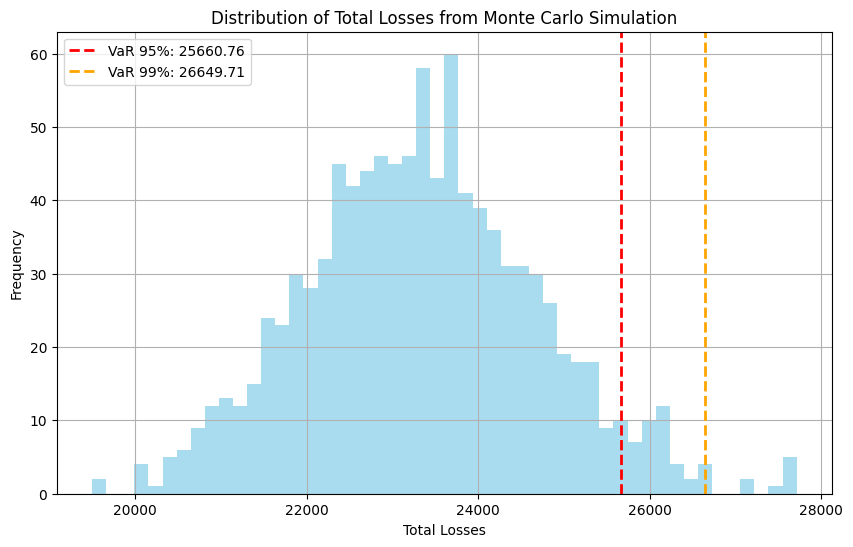

Expected Total Loss: 9.26
95th Percentile Total Loss (VaR 95%): 25660.76
99th Percentile Total Loss (VaR 99%): 26649.71


In [111]:
# Claim_counts holds historical claim frequency data
# Non_zero_claims holds historical non-zero claim severities

# Use the fitted parameters from the Negative Binomial and Log-normal fits
# For claim frequency (Negative Binomial)
params_negbin = [r_negbin, p_negbin]  # Fitted Negative Binomial params
# For claim severity (Log-normal)
params_lognorm = [shape, loc, scale]  # Fitted Log-normal params

# Number of simulations and policies
n_simulations = 1000
n_policies = len(claims_data)

# Pre-alloc_0ate an array for total losses
total_losses = np.zeros(n_simulations)

# Monte Carlo simulation loop
for i in range(n_simulations):
    # Simulate number of claims for all policies at once
    num_claims = nbinom.rvs(r_negbin, p_negbin, size=n_policies)
    
    # Initialize total claim severity for each policy
    total_claim_severity = np.zeros(n_policies)
    
    # For policies with claims, simulate the severity
    for j in range(n_policies):
        if num_claims[j] > 0:
            # Simulate claim severity for each claim and sum them for the policy
            total_claim_severity[j] = lognorm.rvs(shape, loc, scale, size=num_claims[j]).sum()
    
    # Store the total loss for this simulation
    total_losses[i] = total_claim_severity.sum()

    expected_total_loss = total_claim_severity * num_claims


# Calculate expected total loss from the simulation results 
premium = expected_total_loss.mean()

# Calculate Value-at-Risk (VaR) at different confidence levels (95% and 99%)
var_95 = np.percentile(total_losses, 95)
var_99 = np.percentile(total_losses, 99)

# Plot the total losses distribution and highlight VaR levels
plt.figure(figsize=(10, 6))
plt.hist(total_losses, bins=50, color='skyblue', alpha=0.7)
plt.axvline(var_95, color='red', linestyle='dashed', linewidth=2, label=f'VaR 95%: {var_95:.2f}')
plt.axvline(var_99, color='orange', linestyle='dashed', linewidth=2, label=f'VaR 99%: {var_99:.2f}')
plt.title('Distribution of Total Losses from Monte Carlo Simulation')
plt.xlabel('Total Losses')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Printing Risk Measures 
print(f"Expected Total Loss: {premium:.2f}")
print(f"95th Percentile Total Loss (VaR 95%): {var_95:.2f}")
print(f"99th Percentile Total Loss (VaR 99%): {var_99:.2f}")

# Monte carlo per cluster

*Cluster 0*

In [159]:
n_simulations_0 = 100
n_policies_0 = len(df_cluster_0)  # Replace with len(claims_data) if claims_data is defined

simulation_results_0 = pd.DataFrame()

# Monte Carlo simulation loop
for i in range(n_simulations_0):
    # Simulate number of claims for all policies at once (Frequency_0 per year per policy)
    frequency_0 = nbinom.rvs(r_negbin_0, p_negbin_0, size=n_policies_0)
    
    # Initialize total claim severity for each policy
    total_claim_severity_0 = np.zeros(n_policies_0)
    
    # For policies with claims, simulate the severity
    for j in range(n_policies_0):
        if frequency_0[j] > 0:
            severities_0 = lognorm.rvs(shape_0, loc=0, scale=scale_0, size=frequency_0[j])
            total_claim_severity_0[j] = severities_0.sum()

    # Create a temporary DataFrame for this simulation
    temp_df_0 = pd.DataFrame({
        'Policy': np.arange(n_policies_0),
        'Frequency_0': frequency_0,
        'Total_Claim_Severity_0': total_claim_severity_0,
        'Simulation': i
    })
    
    # Append to the main DataFrame
    simulation_results_0 = pd.concat([simulation_results_0, temp_df_0], ignore_index=True)
    
# Compute the sum of all claims (total loss) for each simulation
total_loss_per_simulation = simulation_results_0.groupby('Simulation')['Total_Claim_Severity_0'].sum()
expected_loss = total_loss_per_simulation.mean()

# Now you have the total sum of all claims per simulation
expected_loss

np.float64(29286.41158899035)

Pure Premium: 0.11


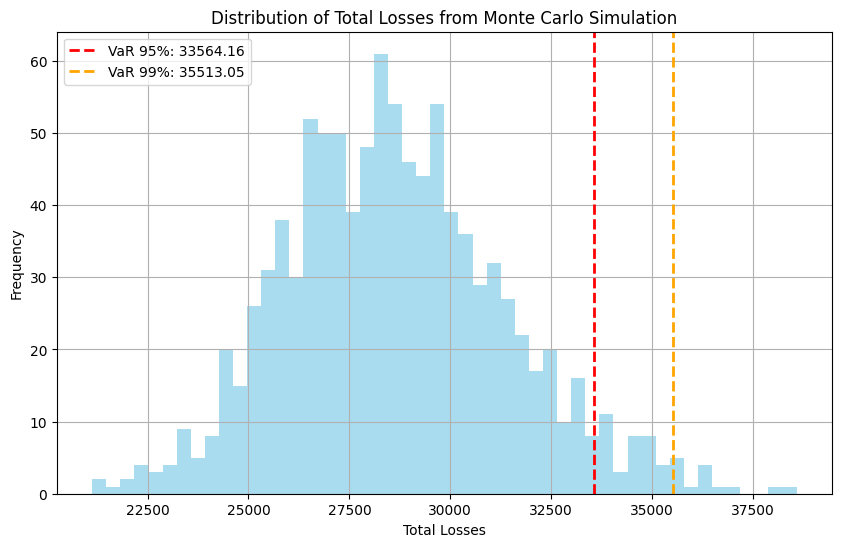

Pure Premium: 0.11
95th Percentile Total Loss (VaR 95%): 33564.16
99th Percentile Total Loss (VaR 99%): 35513.05


In [34]:
# OLD CODE !!!

# Claim_counts holds historical claim frequency data
# Non_zero_claims holds historical non-zero claim severities

# Use the fitted parameters from the Negative Binomial and Log-normal fits
# For claim frequency (Negative Binomial)
params_negbin_0 = [r_negbin_0, p_negbin_0]  # Fitted Negative Binomial params
# For claim severity (Log-normal)
params_lognorm_0 = [shape_0, loc_0, scale_0]  # Fitted Log-normal params

# Number of simulations and policies
n_simulations = 1000
n_policies_0 = len(df_cluster_0)

# Pre-alloc_0ate an array for total losses
total_losses_0 = np.zeros(n_simulations)

# Monte Carlo simulation loop
for i in range(n_simulations):
    # Simulate number of claims for all policies at once
    num_claims_0 = nbinom.rvs(r_negbin_0, p_negbin_0, size=n_policies_0)
    
    # Initialize total claim severity for each policy
    total_claim_severity_0 = np.zeros(n_policies_0)
    
    # For policies with claims, simulate the severity
    for j in range(n_policies_0):
        if num_claims_0[j] > 0:
            # Simulate claim severity for each claim and sum them for the policy
            total_claim_severity_0[j] = lognorm.rvs(shape_0, loc_0, scale_0, size=num_claims_0[j]).sum()
    
    # Store the total loss for this simulation
    total_losses_0[i] = total_claim_severity_0.sum()

# Calculate expected total loss from the simulation results 
#expected_total_loss_0 = np.mean(total_losses_0)

# Calculate expected claim frequency (mean of number of claims across policies)
expected_frequency_0 = np.mean(num_claims_0)

# Calculate expected severity (mean of the total claim severity across claims)
expected_severity_0 = np.mean(total_claim_severity_0[total_claim_severity_0 > 0])  # for policies with claims

# Pure Premium = Frequency * Severity
pure_premium_0 = expected_frequency_0
print(f"Pure Premium: {pure_premium_0:.2f}")

# Calculate Value-at-Risk (VaR) at different confidence levels (95% and 99%)
var_95_0 = np.percentile(total_losses_0, 95)
var_99_0 = np.percentile(total_losses_0, 99)

# Plot the total losses distribution and highlight VaR levels
plt.figure(figsize=(10, 6))
plt.hist(total_losses_0, bins=50, color='skyblue', alpha=0.7)
plt.axvline(var_95_0, color='red', linestyle='dashed', linewidth=2, label=f'VaR 95%: {var_95_0:.2f}')
plt.axvline(var_99_0, color='orange', linestyle='dashed', linewidth=2, label=f'VaR 99%: {var_99_0:.2f}')
plt.title('Distribution of Total Losses from Monte Carlo Simulation')
plt.xlabel('Total Losses')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Printing Risk Measures 
#print(f"Expected Total Loss: {expected_total_loss_0:.2f}")
print(f"Pure Premium: {pure_premium_0:.2f}")
print(f"95th Percentile Total Loss (VaR 95%): {var_95_0:.2f}")
print(f"99th Percentile Total Loss (VaR 99%): {var_99_0:.2f}")

In [64]:
expected_frequency_0 
expected_severity_0

np.float64(4.864595030341474)

*Cluster 1*

In [131]:
# NEW CODE 

n_simulations_1 = 100
n_policies_1 = len(df_cluster_1)  # Replace with len(claims_data) if claims_data is defined

simulation_results_1 = pd.DataFrame()

# Monte Carlo simulation loop
for i in range(n_simulations_1):
    # Simulate number of claims for all policies at once (Frequency_1 per year per policy)
    frequency_1 = nbinom.rvs(r_negbin_1, p_negbin_1, size=n_policies_1)
    
    # Initialize total claim severity for each policy
    total_claim_severity_1 = np.zeros(n_policies_1)
    
    # For policies with claims, simulate the severity
    for j in range(n_policies_1):
        if frequency_1[j] > 0:
            severities_1 = lognorm.rvs(shape_1, loc=0, scale=scale_1, size=frequency_1[j])
            total_claim_severity_1[j] = severities_1.sum()

    # Create a temporary DataFrame for this simulation
    temp_df_1 = pd.DataFrame({
        'Policy': np.arange(n_policies_1),
        'Frequency_1': frequency_1,
        'Total_Claim_Severity_1': total_claim_severity_1,
        'Simulation': i
    })
    
    # Append to the main DataFrame
    simulation_results_1 = pd.concat([simulation_results_1, temp_df_1], ignore_index=True)
    losses_1 = temp_df_1['Total_Claim_Severity_1']*temp_df_1['Frequency_1'].sum()
    
losses_1.mean()

np.float64(1470.6791268594143)

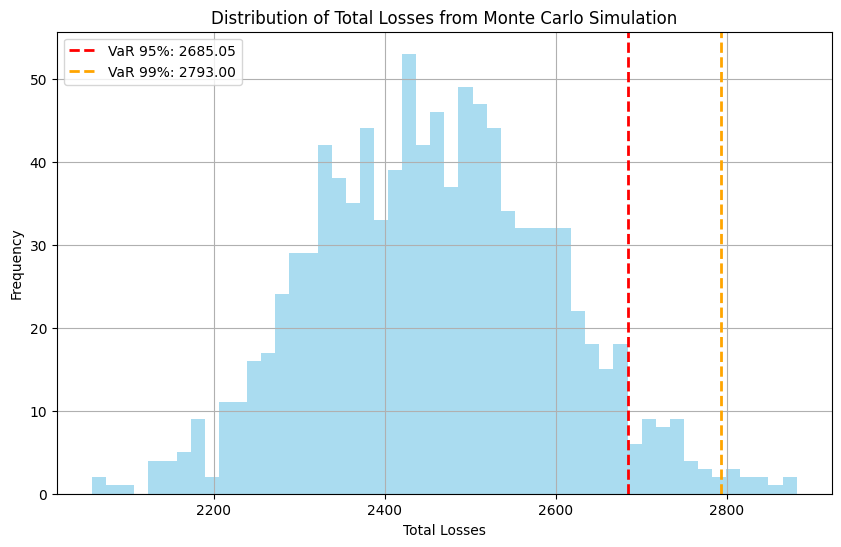

Expected Total Loss: 2458.52
95th Percentile Total Loss (VaR 95%): 2685.05
99th Percentile Total Loss (VaR 99%): 2793.00


In [40]:
# OLD CODE 

# Claim_counts holds historical claim frequency data
# Non_zero_claims holds historical non-zero claim severities

# Use the fitted parameters from the Negative Binomial and Log-normal fits
# For claim frequency (Negative Binomial)
params_negbin_1 = [r_negbin_1, p_negbin_1]  # Fitted Negative Binomial params
# For claim severity (Log-normal)
params_lognorm_1 = [shape_1, loc_1, scale_1]  # Fitted Log-normal params

# Number of simulations and policies
n_simulations = 1000
n_policies_1 = len(df_cluster_1)

# Pre-alloc_1ate an array for total losses
total_losses_1 = np.zeros(n_simulations)

# Monte Carlo simulation loop
for i in range(n_simulations):
    # Simulate number of claims for all policies at once
    num_claims_1 = nbinom.rvs(r_negbin_1, p_negbin_1, size=n_policies_1)
    
    # Initialize total claim severity for each policy
    total_claim_severity_1 = np.zeros(n_policies_1)
    
    # For policies with claims, simulate the severity
    for j in range(n_policies_1):
        if num_claims_1[j] > 0:
            # Simulate claim severity for each claim and sum them for the policy
            total_claim_severity_1[j] = lognorm.rvs(shape_1, loc_1, scale_1, size=num_claims_1[j]).sum()
    
    # Store the total loss for this simulation
    total_losses_1[i] = total_claim_severity_1.sum()

# Calculate expected total loss from the simulation results 
expected_total_loss_1 = np.mean(total_losses_1)

# Calculate Value-at-Risk (VaR) at different confidence levels (95% and 99%)
var_95_1 = np.percentile(total_losses_1, 95)
var_99_1 = np.percentile(total_losses_1, 99)

# Plot the total losses distribution and highlight VaR levels
plt.figure(figsize=(10, 6))
plt.hist(total_losses_1, bins=50, color='skyblue', alpha=0.7)
plt.axvline(var_95_1, color='red', linestyle='dashed', linewidth=2, label=f'VaR 95%: {var_95_1:.2f}')
plt.axvline(var_99_1, color='orange', linestyle='dashed', linewidth=2, label=f'VaR 99%: {var_99_1:.2f}')
plt.title('Distribution of Total Losses from Monte Carlo Simulation')
plt.xlabel('Total Losses')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Printing Risk Measures 
print(f"Expected Total Loss: {expected_total_loss_1:.2f}")
print(f"95th Percentile Total Loss (VaR 95%): {var_95_1:.2f}")
print(f"99th Percentile Total Loss (VaR 99%): {var_99_1:.2f}")

*Cluster 2*

In [143]:
# NEW CODE 
n_simulations_2 = 100
n_policies_2 = len(df_cluster_2)  # Replace with len(claims_data) if claims_data is defined

simulation_results_2 = pd.DataFrame()

# Monte Carlo simulation loop
for i in range(n_simulations_2):
    # Simulate number of claims for all policies at once (Frequency_2 per year per policy)
    frequency_2 = nbinom.rvs(r_negbin_2, p_negbin_2, size=n_policies_2)
    
    # Initialize total claim severity for each policy
    total_claim_severity_2 = np.zeros(n_policies_2)
    
    # For policies with claims, simulate the severity
    for j in range(n_policies_2):
        if frequency_2[j] > 0:
            severities_2 = lognorm.rvs(shape_2, loc=0, scale=scale_2, size=frequency_2[j])
            total_claim_severity_2[j] = severities_2.sum()

    # Create a temporary DataFrame for this simulation
    temp_df_2 = pd.DataFrame({
        'Policy': np.arange(n_policies_2),
        'Frequency_2': frequency_2,
        'Total_Claim_Severity_2': total_claim_severity_2,
        'Simulation': i
    })
    
    # Append to the main DataFrame
    simulation_results_2 = pd.concat([simulation_results_2, temp_df_2], ignore_index=True)
    losses_2 = temp_df_2['Total_Claim_Severity_2']*temp_df_2['Frequency_2'].sum()
    
losses_2.mean()

np.float64(3233.199191632906)

In [ ]:
# OLD CODE
# Claim_counts holds historical claim frequency data
# Non_zero_claims holds historical non-zero claim severities

# Use the fitted parameters from the Negative Binomial and Log-normal fits
# For claim frequency (Negative Binomial)
params_negbin_2 = [r_negbin_2, p_negbin_2]  # Fitted Negative Binomial params
# For claim severity (Log-normal)
params_lognorm_2 = [shape_2, loc_2, scale_2]  # Fitted Log-normal params

# Number of simulations and policies
n_simulations = 1000
n_policies_2 = len(df_cluster_2)

# Pre-alloc_2ate an array for total losses
total_losses_2 = np.zeros(n_simulations)

# Monte Carlo simulation loop
for i in range(n_simulations):
    # Simulate number of claims for all policies at once
    num_claims_2 = nbinom.rvs(r_negbin_2, p_negbin_2, size=n_policies_2)
    
    # Initialize total claim severity for each policy
    total_claim_severity_2 = np.zeros(n_policies_2)
    
    # For policies with claims, simulate the severity
    for j in range(n_policies_2):
        if num_claims_2[j] > 0:
            # Simulate claim severity for each claim and sum them for the policy
            total_claim_severity_2[j] = lognorm.rvs(shape_2, loc_2, scale_2, size=num_claims_2[j]).sum()
    
    # Store the total loss for this simulation
    total_losses_2[i] = total_claim_severity_2.sum()

# Calculate expected total loss from the simulation results 
expected_total_loss_2 = np.mean(total_losses_2)

# Calculate Value-at-Risk (VaR) at different confidence levels (95% and 99%)
var_95_2 = np.percentile(total_losses_2, 95)
var_99_2 = np.percentile(total_losses_2, 99)

# Plot the total losses distribution and highlight VaR levels
plt.figure(figsize=(10, 6))
plt.hist(total_losses_2, bins=50, color='skyblue', alpha=0.7)
plt.axvline(var_95_2, color='red', linestyle='dashed', linewidth=2, label=f'VaR 95%: {var_95_2:.2f}')
plt.axvline(var_99_2, color='orange', linestyle='dashed', linewidth=2, label=f'VaR 99%: {var_99_2:.2f}')
plt.title('Distribution of Total Losses from Monte Carlo Simulation')
plt.xlabel('Total Losses')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Printing Risk Measures 
print(f"Expected Total Loss: {expected_total_loss_2:.2f}")
print(f"95th Percentile Total Loss (VaR 95%): {var_95_2:.2f}")
print(f"99th Percentile Total Loss (VaR 99%): {var_99_2:.2f}")

# ANNEXE

# Fitting Claim Frequency Distributions

## Fitting with Poisson, Binomial and Negative Binomial Distribution
We fit the claim frequency data to three different distributions: Poisson, Binomial, and Negative Binomial. For each distribution, the parameters are estimated using the respective fitting methods. The fitted parameters are then used to plot the frequency distribution.

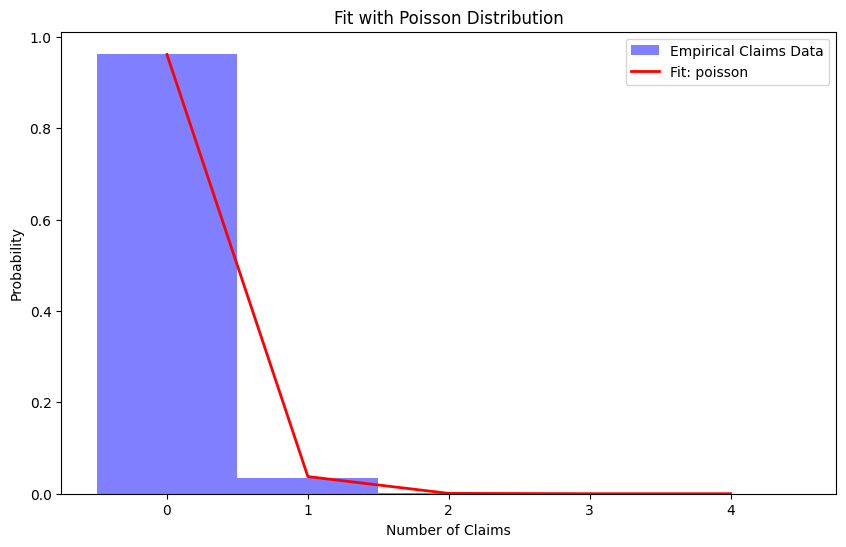

AIC for Fit with Poisson Distribution: 33460.499374859624
BIC for Fit with Poisson Distribution: 33470.0122603238


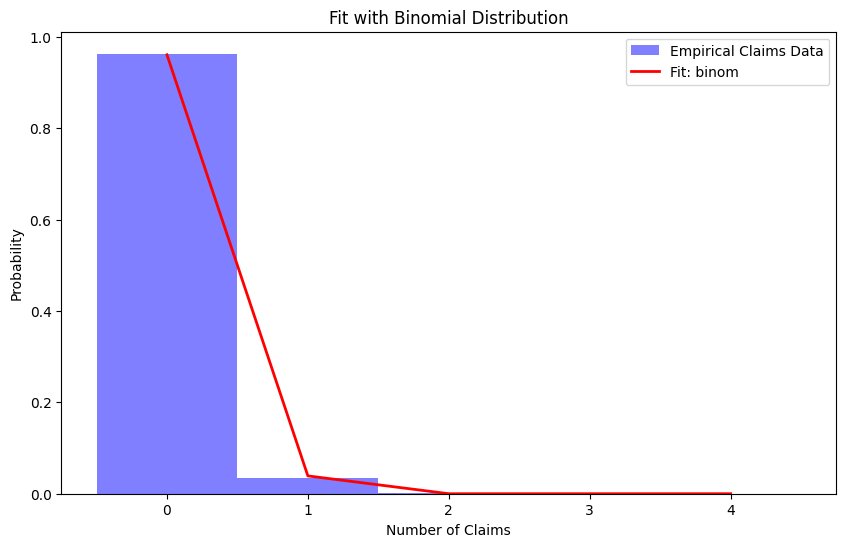

AIC for Fit with Binomial Distribution: 40311.18360245922
BIC for Fit with Binomial Distribution: 40330.20933338556


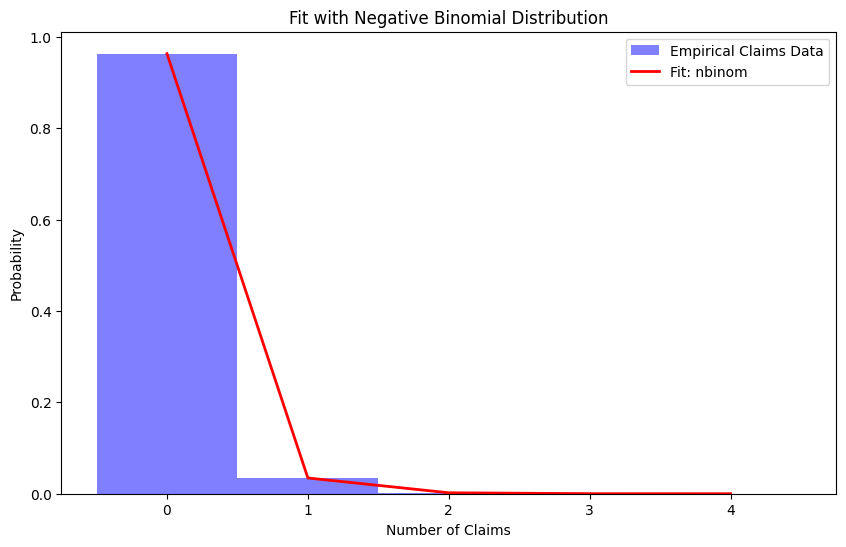

AIC for Fit with Negative Binomial Distribution: 33220.908366396994
BIC for Fit with Negative Binomial Distribution: 33239.934097323334


In [79]:
# Poisson Distribution Fitting
lambda_poisson = np.mean(claim_counts)
params_poisson = [lambda_poisson]
plot_fit(claim_counts, poisson, params_poisson, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting
n_trials = 1  # This should be adjusted based on your specific scenario
p_success = np.mean(claim_counts) / n_trials
params_binom = [n_trials, p_success]
plot_fit(claim_counts, binom, params_binom, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting
r_negbin = (np.mean(claim_counts)**2) / (np.var(claim_counts) - np.mean(claim_counts))
p_negbin = r_negbin / (r_negbin + np.mean(claim_counts))
params_negbin = [r_negbin, p_negbin]
plot_fit(claim_counts, nbinom, params_negbin, 'Fit with Negative Binomial Distribution', dist_type='discrete')

In [80]:
def calculate_aic(n, ll, k):
    """
    Calculate Akaike Information Criterion.
    """
    return 2*k - 2*ll + 2*k*(k+1)/(n-k-1)

def calculate_bic(n, ll, k):
    """
    Calculate Bayesian Information Criterion.
    """
    return -2*ll + k*np.log(n)

def plot_fit_severity(x, dist, params, title):
    plt.figure(figsize=(10, 6))
    count, bins, ignored = plt.hist(x, bins=30, density=True, alpha=0.5, color='g', label='Empirical Severity Data')
    xmin, xmax = plt.xlim()
    x_range = np.linspace(xmin, xmax, 100)

    if dist != pareto:
        probabilities = dist.pdf(x_range, *params)
        log_likelihood = np.sum(np.log(dist.pdf(x, *params)))
    else:
        probabilities = dist.pdf(x_range, *params)
        log_likelihood = np.sum(np.log(dist.pdf(x, *params)))

    plt.plot(x_range, probabilities, 'k-', linewidth=2, label=f'Fit: {dist.name}')
    plt.title(title)
    plt.xlabel('Claim Amount')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Calculate AIC and BIC
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

# Fitting Claim Severity Distributions

## Fitting with Log-normal Distribution, Pareto and Gamma
We fit the claim severity data to a log-normal, Pareto and Gamma distribution. The parameters of the distribution are estimated using the `lognorm.fit` method with `floc` set to 0. 
The fitted parameters are then used to plot the severity distribution

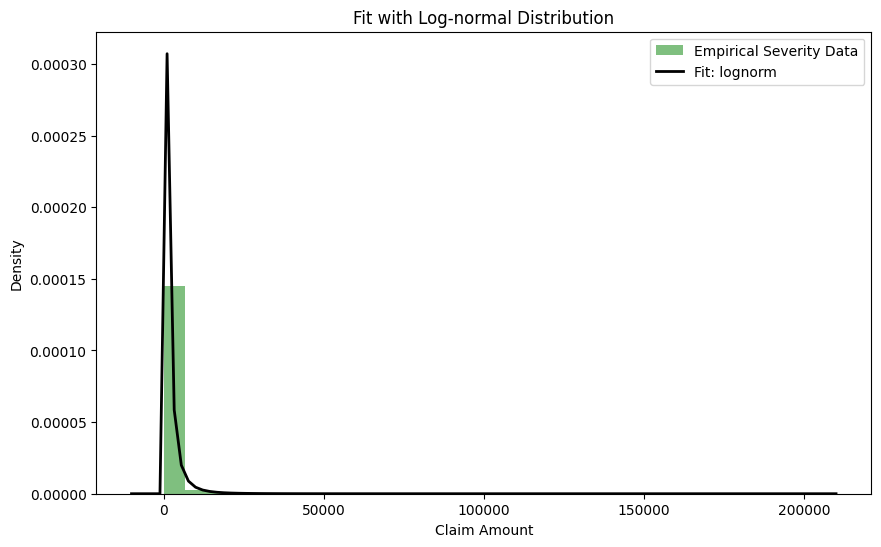

AIC for Fit with Log-normal Distribution: 61901.186253035194
BIC for Fit with Log-normal Distribution: 61919.79944829225


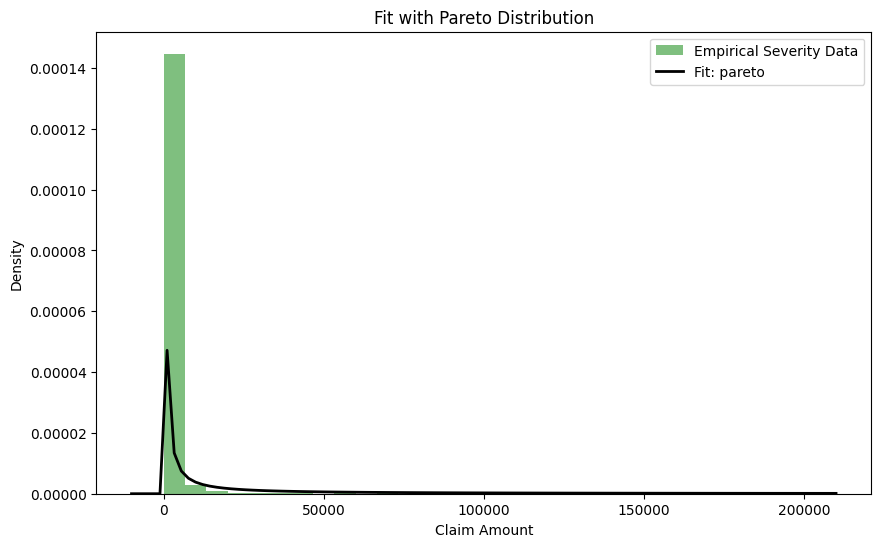

AIC for Fit with Pareto Distribution: 71878.08174119866
BIC for Fit with Pareto Distribution: 71896.69493645572


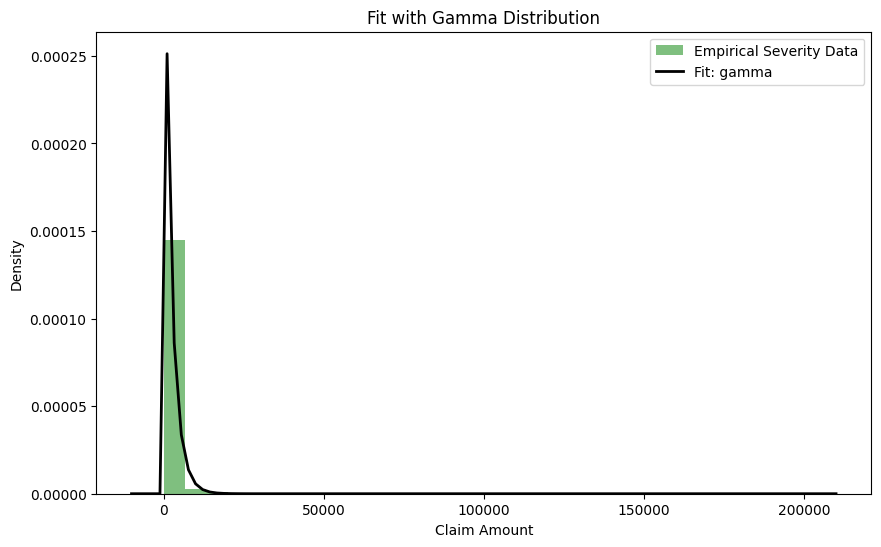

AIC for Fit with Gamma Distribution: 63202.40850800119
BIC for Fit with Gamma Distribution: 63221.021703258244


In [81]:
# Log-normal fitting
shape, loc, scale = lognorm.fit(non_zero_claims, floc=0)
params_lognorm = [shape, loc, scale]
plot_fit_severity(non_zero_claims, lognorm, params_lognorm, 'Fit with Log-normal Distribution')

# Pareto fitting
b, loc, scale = pareto.fit(non_zero_claims, floc=0)  # Fitting with floc set to 0
params_pareto = [b, loc, scale]
plot_fit_severity(non_zero_claims, pareto, params_pareto, 'Fit with Pareto Distribution')

# Gamma fitting
alpha, loc, beta = gamma.fit(non_zero_claims, floc=0)  # Adjusting fit parameters as needed
params_gamma = [alpha, loc, beta]
plot_fit_severity(non_zero_claims, gamma, params_gamma, 'Fit with Gamma Distribution')

# Choosing the Best Distribution for Claim Frequency and Severity

## Claim Frequency Distribution

To determine the best distribution for claim frequency, we compared the AIC and BIC values for Poisson, Binomial, and Negative Binomial distributions. The distribution with the lowest AIC and BIC values is considered the best fit.

### AIC and BIC Values for Claim Frequency Distributions:
- **Poisson Distribution**:
  - AIC: 33460.499374859624
  - BIC: 33470.0122603238
- **Negative Binomial Distribution**:
  - AIC: 33220.908366396994
  - BIC: 33239.934097323334
- **Binomial Distribution**:
  - AIC: 40311.18360245922
  - BIC: 40330.20933338556

### Conclusion:
The Negative Binomial distribution has the lowest AIC and BIC values, indicating that it is the best fit for the claim frequency data.

## Claim Severity Distribution

To determine the best distribution for claim severity, we compared the AIC and BIC values for Log-normal, Pareto, and Gamma distributions. The distribution with the lowest AIC and BIC values is considered the best fit.

### AIC and BIC Values for Claim Severity Distributions:
- **Log-normal Distribution**:
  - AIC: 61901.186253035194
  - BIC: 61919.79944829225
- **Pareto Distribution**:
  - AIC: 71878.08174119866
  - BIC: 71896.69493645572
- **Gamma Distribution**:
  - AIC: 63202.40850800119
  - BIC: 63221.021703258244

### Conclusion:
The Log-normal distribution has the lowest AIC and BIC values, indicating that it is the best fit for the claim severity data.

# Predicting Total Losses using Monte Carlo Simulation

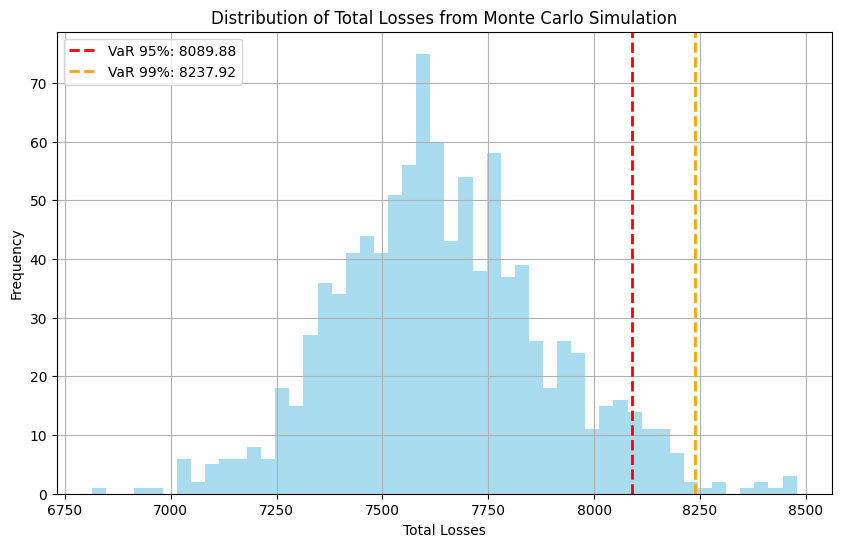

Expected Total Loss: 7643.47
95th Percentile Total Loss (VaR 95%): 8089.88
99th Percentile Total Loss (VaR 99%): 8237.92


In [63]:
# Claim_counts holds historical claim frequency data
# Non_zero_claims holds historical non-zero claim severities

# Use the fitted parameters from the Negative Binomial and Log-normal fits
# For claim frequency (Negative Binomial)
params_negbin = [r_negbin, p_negbin]  # Fitted Negative Binomial params
# For claim severity (Log-normal)
params_lognorm = [shape, loc, scale]  # Fitted Log-normal params

# Number of simulations and policies
n_simulations = 1000
n_policies = len(claims_data)

# Pre-allocate an array for total losses
total_losses = np.zeros(n_simulations)

# Monte Carlo simulation loop
for i in range(n_simulations):
    # Simulate number of claims for all policies at once
    num_claims = nbinom.rvs(r_negbin, p_negbin, size=n_policies)
    
    # Initialize total claim severity for each policy
    total_claim_severity = np.zeros(n_policies)
    
    # For policies with claims, simulate the severity
    for j in range(n_policies):
        if num_claims[j] > 0:
            # Simulate claim severity for each claim and sum them for the policy
            total_claim_severity[j] = lognorm.rvs(shape, loc, scale, size=num_claims[j]).sum()
    
    # Store the total loss for this simulation
    total_losses[i] = total_claim_severity.sum()

# Calculate expected total loss from the simulation results 
expected_total_loss = np.mean(total_losses)

# Calculate Value-at-Risk (VaR) at different confidence levels (95% and 99%)
var_95 = np.percentile(total_losses, 95)
var_99 = np.percentile(total_losses, 99)

# Plot the total losses distribution and highlight VaR levels
plt.figure(figsize=(10, 6))
plt.hist(total_losses, bins=50, color='skyblue', alpha=0.7)
plt.axvline(var_95, color='red', linestyle='dashed', linewidth=2, label=f'VaR 95%: {var_95:.2f}')
plt.axvline(var_99, color='orange', linestyle='dashed', linewidth=2, label=f'VaR 99%: {var_99:.2f}')
plt.title('Distribution of Total Losses from Monte Carlo Simulation')
plt.xlabel('Total Losses')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Printing Risk Measures 
print(f"Expected Total Loss: {expected_total_loss:.2f}")
print(f"95th Percentile Total Loss (VaR 95%): {var_95:.2f}")
print(f"99th Percentile Total Loss (VaR 99%): {var_99:.2f}")

In [70]:
# Create a dictionary to store the simulation results and risk measures
simulation_results = {
    'Total Loss': total_losses  # Total losses from each simulation
}

# Convert the dictionary into a DataFrame
df_simulation_results = pd.DataFrame(simulation_results)


# Display the first few rows of the simulation results DataFrame
df_simulation_results

,Total Loss
0,7387.002300
1,7268.854283
2,7198.106409
3,7285.600511
4,7809.945424
...,...
995,7444.639275
996,7530.931955
997,7398.227638
998,7814.625246


# Resulting Distribution from Convolution

In this Monte Carlo simulation, we model the claim frequency using a Negative Binomial distribution and the claim severity using a Log-normal distribution. The resulting distribution of total losses from this convolution is an aggregated loss distribution.

## Characteristics of the Simulated Distribution:
- **Claim Frequency**: Modeled using a Negative Binomial distribution.
- **Claim Severity**: Modeled using a Log-normal distribution.
- **Total Losses**: The sum of individual claim severities for each simulated number of claims.

### Analysis of Simulated Total Losses:
- **Expected Total Loss**: The mean of the total losses from the simulations.
- **Value-at-Risk (VaR)**: Calculated at different confidence levels (e.g., 95% and 99%) to assess the risk of extreme losses.

# Cluster analysis

In [82]:
# Define the age bins and corresponding labels
bins = [0, 4, 14, 19, 24, 34, 44, 54, 64, 100]
labels = ['0 - 4', '5 - 14', '15 - 19', '20 - 24', '25 - 34', '35 - 44', '45 - 54', '55 - 64', '65 +']

# Create a new column 'Age Group' based on these bins
claims_data['Age Group'] = pd.cut(claims_data['DrivAge'], bins=bins, labels=labels, right=True)

# Handle missing or undefined ages
claims_data['Age Group'] = claims_data['Age Group'].cat.add_categories('Not stated')
claims_data['Age Group'].fillna('Not stated', inplace=True)

# Create a new column 'Vehicle Group' based on these bins
claims_data['Vehicle Group'] = pd.cut(claims_data['VehAge'], bins=bins, labels=labels, right=True)

# Handle missing or undefined ages
claims_data['Vehicle Group'] = claims_data['Vehicle Group'].cat.add_categories('Not stated')
claims_data['Vehicle Group'].fillna('Not stated', inplace=True)

# Create a new column 'Bonus / Malus' based on the value in 'BonusMalus'
claims_data['Bonus / Malus'] = claims_data['BonusMalus'].apply(lambda x: 'Bonus' if x < 100 else ('Malus' if x > 100 else 'Neutral'))

# Define the vehicle power bins and corresponding labels
bins_2 = [4, 6, 9, 12, 15]
labels = ['4 - 6', '7 - 9', '10 - 12', '13 - 15']

# Create a new column 'Vehicle power' based on these bins
claims_data['Vehicle power'] = pd.cut(claims_data['VehPower'], bins=bins_2, labels=labels, right=True)

# Handle missing or undefined ages
claims_data['Vehicle power'] = claims_data['Vehicle power'].cat.add_categories('Not stated')
claims_data['Vehicle power'].fillna('Not stated', inplace=True)

warnings.filterwarnings("ignore")

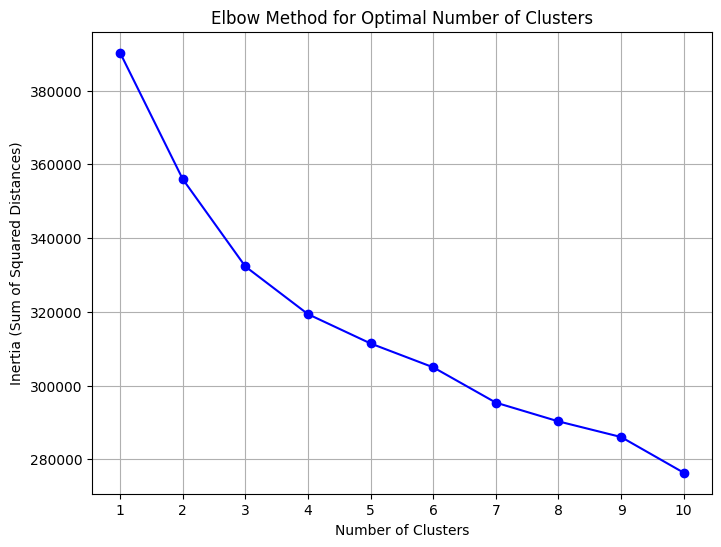

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

# Step 1: Ensure df_1 is a correct copy of claims_data
df_1 = claims_data.copy()

# Columns to consider for clustering:
categorical_columns = ['Age Group', 'Vehicle Group', 'Vehicle power', 'Bonus / Malus', 'Area', 'Region']

# Step 2: Data Preprocessing using ColumnTransformer
# One-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Step 3: Elbow method to determine the optimal number of clusters
inertia = []
cluster_range = range(1, 11)  # Test for clusters from 1 to 10

for n_clusters in cluster_range:
    # Build pipeline with KMeans clustering for each n_clusters
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))])
    
    # Fit the pipeline to the data
    pipeline.fit(df_1)
    
    # Append the inertia (sum of squared distances to centroids)
    inertia.append(pipeline.named_steps['kmeans'].inertia_)

# Step 4: Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

# The inertia drops sharply from 1 to 3 clusters, with diminishing returns after 3. The elbow is at 3 clusters, suggesting that 3 clusters is likely the optimal number (WCSS).

In [87]:
from sklearn.pipeline import Pipeline

# Fix: Ensure df_1 is a correct copy of claims_data
df_1 = claims_data.copy()

# Columns to consider for clustering:
# We will treat 'Age Group', 'Vehicle Group', and 'Vehicle power' as categorical for now.
categorical_columns = ['Age Group', 'Vehicle Group', 'Vehicle power', 'Bonus / Malus', 'Area', 'Region']

# Step 1: Data Preprocessing using ColumnTransformer
# One-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)  # One-hot encode categorical columns
    ])

# Step 2: Build the pipeline
# The pipeline will first preprocess the data and then apply KMeans clustering
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('kmeans', KMeans(n_clusters=3, random_state=42))])

# Step 3: Fit the pipeline to your data
pipeline.fit(df_1)

# Step 4: Predict clusters and store the result in 'Risk Cluster'
df_1['Risk Cluster'] = pipeline.named_steps['kmeans'].labels_

# Step 5: Analyze the clusters
# Count how many data points belong to each cluster
print(df_1['Risk Cluster'].value_counts())

# Optional: Display the DataFrame with the new 'Risk Cluster' column
print(df_1.head())

# Step 6: Cluster summary
# Since most columns are categorical, we will calculate frequency counts instead of mean
cluster_summary = df_1.groupby('Risk Cluster').size()

print("Cluster Summary (Cluster Size):")
cluster_summary


Risk Cluster
1    39441
0    33361
2    27198
Name: count, dtype: int64
     IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0  2271893        0      0.83    E         5      17       53          64   
1  1111864        0      0.24    E         5       2       27          64   
2    72908        0      0.50    E         7      11       67          50   
3  2283027        0      0.08    B         5       8       28          60   
4  1123838        0      0.03    A        11       1       38          50   

  VehBrand   VehGas  Density Region  ClaimAmount Age Group Vehicle Group  \
0       B2   Diesel     3317    R93          0.0   45 - 54       15 - 19   
1       B3   Diesel     2740    R22          0.0   25 - 34         0 - 4   
2       B3  Regular     4762    R93          0.0      65 +        5 - 14   
3       B1   Diesel       64    R91          0.0   25 - 34        5 - 14   
4       B2  Regular       16    R24          0.0   35 - 44         0 - 4   

  Bonus 

Risk Cluster
0    33361
1    39441
2    27198
dtype: int64

In [89]:
# Group by 'Risk Cluster' and calculate the average for 'Claim Frequency' and 'Claim Severity'
cluster_metrics = df_1.groupby('Risk Cluster').agg({
    'ClaimNb': 'mean', "ClaimAmount" : 'mean'
}).reset_index()

# Display the computed metrics
print(cluster_metrics)

# Increasing risk by cluster, our number of clusters make sense.

   Risk Cluster   ClaimNb  ClaimAmount
0             0  0.036450    69.898809
1             1  0.038006    77.157988
2             2  0.043643    84.010086


In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom, lognorm

# Assuming the 'Risk Cluster' column already exists in claims_data, and it has been divided into clusters.
# For each cluster, we will calculate expected losses based on the Monte Carlo simulations.

# Pre-allocate a dictionary to store losses for each cluster
cluster_losses = {cluster: np.zeros(n_simulations) for cluster in df_1['Risk Cluster'].unique()}

# Number of simulations
n_simulations = 1000

# Monte Carlo simulation loop for each cluster
for cluster in df_1['Risk Cluster'].unique():
    # Filter data for the current cluster
    cluster_data = df_1[df_1['Risk Cluster'] == cluster]
    n_policies = len(cluster_data)  # Number of policies in this cluster

    # Simulate losses for this cluster
    for i in range(n_simulations):
        # Simulate number of claims (ClaimNb) for all policies at once using Negative Binomial distribution
        num_claims = nbinom.rvs(r_negbin, p_negbin, size=n_policies)
        
        # Initialize total claim severity (ClaimAmount) for each policy
        total_claim_severity = np.zeros(n_policies)
        
        # For policies with claims, simulate the severity using Log-normal distribution
        for j in range(n_policies):
            if num_claims[j] > 0:
                # Simulate claim severity for each claim and sum them for the policy
                total_claim_severity[j] = lognorm.rvs(shape, loc, scale, size=num_claims[j]).sum()
        
        # Store the total loss for this simulation for the current cluster
        cluster_losses[cluster][i] = total_claim_severity.sum()

# Calculate expected total loss and VaR for each cluster
cluster_expected_losses = {}
cluster_var_95 = {}
cluster_var_99 = {}

for cluster in cluster_losses.keys():
    cluster_expected_losses[cluster] = np.mean(cluster_losses[cluster])
    cluster_var_95[cluster] = np.percentile(cluster_losses[cluster], 95)
    cluster_var_99[cluster] = np.percentile(cluster_losses[cluster], 99)

    # Print results for each cluster
    print(f"Cluster {cluster}:")
    print(f"  Expected Total Loss: {cluster_expected_losses[cluster]:.2f}")
    print(f"  95th Percentile Total Loss (VaR 95%): {cluster_var_95[cluster]:.2f}")
    print(f"  99th Percentile Total Loss (VaR 99%): {cluster_var_99[cluster]:.2f}")
    print()


Cluster 2:
  Expected Total Loss: 2079.82
  95th Percentile Total Loss (VaR 95%): 2294.41
  99th Percentile Total Loss (VaR 99%): 2379.01

Cluster 0:
  Expected Total Loss: 2548.04
  95th Percentile Total Loss (VaR 95%): 2779.52
  99th Percentile Total Loss (VaR 99%): 2889.34

Cluster 1:
  Expected Total Loss: 3015.03
  95th Percentile Total Loss (VaR 95%): 3284.43
  99th Percentile Total Loss (VaR 99%): 3397.71



# ANNEXE

# Logistic Regression: Predict the probability of filing a claim (i.e., whether a claim is made or not)

## Goal: Understand which characteristics increase or decrease the likelihood of a policyholder filing a claim (frequency)

In [51]:
# Create binary variable for claims (1 if there was at least one claim, 0 otherwise)
claims_data['Claim_binary_variable'] = claims_data['ClaimNb'].apply(lambda x: 1 if x > 0 else 0)

# Convert categorical variables to dummy variables (e.g., Area, VehBrand, VehGas, Region)
claims_data = pd.get_dummies(claims_data, columns=['Area', 'VehBrand', 'VehGas', 'Region'], drop_first=True, dtype = int)

# Select the independent variables (Excluding IDpol and ClaimAmount)
independent_vars = ['Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

# Adding dummy variables to independent_vars for policyholder's area, vehicle's brand, the type of gas used and for the region of the policyholder
independent_vars += [col for col in claims_data.columns if col.startswith('Area_') or col.startswith('VehBrand_') or col.startswith('VehGas_') or col.startswith('Region_')]

# Add constant term to the model
X = sm.add_constant(claims_data[independent_vars])

# Define the dependent variable
y = claims_data['Claim_binary_variable']

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.148120
         Iterations 8
                             Logit Regression Results                            
Dep. Variable:     Claim_binary_variable   No. Observations:               100000
Model:                             Logit   Df Residuals:                    99956
Method:                              MLE   Df Model:                           43
Date:                   Thu, 10 Oct 2024   Pseudo R-squ.:                 0.05745
Time:                           15:02:59   Log-Likelihood:                -14812.
converged:                          True   LL-Null:                       -15715.
Covariance Type:               nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -6.6306      0.159    -41.626      0.000      -6.943      

### Summary of Logistic Regression Model Interpretation
Here is a summary of the key findings:

#### Significant Variables

1. **VehPower**
   - **Impact**: Positive
   - **Interpretation**: Higher vehicle power increases the likelihood of an insurance claim.

2. **VehAge**
   - **Impact**: Negative
   - **Interpretation**: Older vehicles are less likely to have insurance claims.

3. **DrivAge**
   - **Impact**: Positive
   - **Interpretation**: Older drivers are more likely to file insurance claims.

4. **BonusMalus**
   - **Impact**: Positive
   - **Interpretation**: A higher Bonus-Malus coefficient increases the likelihood of an insurance claim.

5. **Area (C, D, E, F)**
   - **Impact**: Positive
   - **Interpretation**: Certain geographical areas (C, D, E, F) have a higher likelihood of insurance claims.

6. **VehBrand (B11, B13)**
   - **Impact**: Positive
   - **Interpretation**: Certain vehicle brands (B11, B13) are associated with a higher likelihood of insurance claims.

7. **VehBrand (B12)**
   - **Impact**: Negative
   - **Interpretation**: The vehicle brand B12 is associated with a lower likelihood of insurance claims.

8. **VehGas (Regular)**
   - **Impact**: Negative
   - **Interpretation**: Vehicles using regular gas are less likely to have insurance claims.

9. **Region (R73, R82)**
   - **Impact**: Mixed
   - **Interpretation**: Certain regions (R73, R82) have significant impacts on the likelihood of insurance claims.

10. **Interaction Terms**
    - **DrivAge_VehPower**: Not significant
    - **Exposure_BonusMalus**: Positive and significant
    - **Interpretation**: The interaction between Exposure and Bonus-Malus significantly increases the likelihood of an insurance claim.

#### Non-Significant Variables

1. **Exposure**
2. **Density**
3. **Several Areas, Vehicle Brands, and Regions**

These variables do not have a statistically significant impact on the likelihood of an insurance claim.

### Conclusion

The model identifies several key factors that significantly influence the probability of an insurance claim. These insights can be used to develop a better Risk Group Assignment Algorithm and adjust insurance premiums. Variables such as vehicle power, age of the vehicle, age of the driver, and certain geographical areas and vehicle brands play a crucial role in predicting insurance claims in our dataset.

In [52]:
# Filter the dataset for policyholders who made a claim
claims_with_claims = claims_data[claims_data['ClaimNb'] > 0]

# Log-transform the dependent variable (ClaimAmount)
claims_with_claims['log_ClaimAmount'] = np.log(claims_with_claims['ClaimAmount'])

# Define the independent variables (same as used for frequency)
independent_vars_severity = ['Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
independent_vars_severity += [col for col in claims_with_claims.columns if col.startswith('Area_') or col.startswith('VehBrand_') or col.startswith('VehGas_') or col.startswith('Region_')]

# Add constant term
X_severity = sm.add_constant(claims_with_claims[independent_vars_severity])

# Dependent variable (log-transformed ClaimAmount)
y_severity = claims_with_claims['log_ClaimAmount']

# Fit the GLM for claim severity with a log-normal distribution and log link function 
# Gaussian family with a log link for modeling the log-normal distribution of claim amounts 
glm_severity = sm.GLM(y_severity, X_severity, family=sm.families.Gaussian(sm.families.links.log())).fit()

# View the summary of the severity model
print(glm_severity.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        log_ClaimAmount   No. Observations:                 3665
Model:                            GLM   Df Residuals:                     3621
Model Family:                Gaussian   Df Model:                           43
Link Function:                    log   Scale:                          1.3098
Method:                          IRLS   Log-Likelihood:                -5673.0
Date:                Thu, 10 Oct 2024   Deviance:                       4742.8
Time:                        15:03:25   Pearson chi2:                 4.74e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.03802
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.8548      0.025     73.

/var/folders/_j/nh059vw94tn4ypg5kqrr4hm40000gn/T/ipykernel_68811/564112350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claims_with_claims['log_ClaimAmount'] = np.log(claims_with_claims['ClaimAmount'])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [362]:
# Vérifier les valeurs de Predicted_Frequency et Predicted_Severity
print(claims_data[['Predicted_Frequency', 'Predicted_Severity']].describe())

       Predicted_Frequency  Predicted_Severity
count        100000.000000         3665.000000
mean              0.036650          995.442672
std               0.028356          240.492042
min               0.002617          541.930626
25%               0.016748          819.207391
50%               0.029972          953.753560
75%               0.048654         1119.532463
max               0.824045         2526.256090


In [360]:
# Predict claim frequency using the logistic regression model
claims_data['Predicted_Frequency'] = logit_model.predict(X)

# Predict claim severity using the GLM for severity (only for policyholders with claims)
claims_with_claims['Predicted_Severity_log'] = glm_severity.predict(X_severity)

# Exponentiate the predicted severity to revert the log transformation
claims_with_claims['Predicted_Severity'] = np.exp(claims_with_claims['Predicted_Severity_log'])

# Merge the severity predictions back to the full dataset
claims_data = claims_data.merge(claims_with_claims[['Predicted_Severity']], left_index=True, right_index=True, how='left')

# For policyholders with no claims (ClaimNb == 0), set Predicted_Severity as NaN to exclude them from the Expected_Loss calculation
claims_data.loc[claims_data['ClaimNb'] == 0, 'Predicted_Severity'] = float('nan')

# Calculate the total expected loss for policyholders, considering only those with ClaimNb > 0
claims_data['Expected_Loss'] = claims_data['Predicted_Frequency'] * claims_data['Predicted_Severity']

# Display the results, removing rows with NaN values (i.e., policyholders with no expected loss)
claims_data[['Predicted_Frequency', 'Predicted_Severity', 'Expected_Loss']].dropna()

/var/folders/xs/v3nn216s5j37yby_qfjm69940000gn/T/ipykernel_6684/1032648063.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claims_with_claims['Predicted_Severity_log'] = glm_severity.predict(X_severity)
/var/folders/xs/v3nn216s5j37yby_qfjm69940000gn/T/ipykernel_6684/1032648063.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claims_with_claims['Predicted_Severity'] = np.exp(claims_with_claims['Predicted_Severity_log'])


,Predicted_Frequency,Predicted_Severity,Expected_Loss
13,0.052802,1052.693080,55.584762
44,0.076519,932.815938,71.377714
112,0.040078,1323.737470,53.053253
126,0.088238,1079.150204,95.222409
140,0.024008,1292.744398,31.036567
...,...,...,...
99809,0.085930,828.529568,71.195449
99863,0.021017,1378.720610,28.976745
99905,0.062138,836.461546,51.975658
99986,0.070773,1009.020512,71.411237


In [349]:
# Display basic statistics on expected losses
claims_data['Expected_Loss'].describe()

count    3665.000000
mean       59.949199
std        70.726604
min         5.293621
25%        28.511096
50%        43.354652
75%        67.040959
max      1668.784147
Name: Expected_Loss, dtype: float64

In [43]:
# Check for correlation between risk caracteristics
claims_data[['VehPower', 'DrivAge', 'BonusMalus', 'Density', 'Exposure']].corr()

,VehPower,DrivAge,BonusMalus,Density,Exposure
VehPower,1.000000,0.028375,-0.077144,0.044586,-0.043155
DrivAge,0.028375,1.000000,-0.480037,-0.005337,0.176111
BonusMalus,-0.077144,-0.480037,1.000000,0.080366,-0.182107
Density,0.044586,-0.005337,0.080366,1.000000,-0.070458
Exposure,-0.043155,0.176111,-0.182107,-0.070458,1.000000


# Risk Group Assignment Algorithm based on  individual characteristics

## Principles for Risk Categorization (Based on the lecture : Topic 2B: Underwriting): 

Actuarial Criteria:

- **Accuracy**: Variables must have a clear link to expected costs and losses, which our regression analysis helps confirm.
- **Homogeneity**: Each risk group should have similar expected claim costs.
- **Credibility**: Risk categories should be large enough to be statistically reliable.
- **Predictive Stability**: Differences between categories should remain stable over time.

Ce code calcule des seuils pour classifier les risques en fonction de la fréquence et de la sévérité des réclamations avec des quantiles, et applique cette classification à chaque titulaire de police.

In [281]:
# Function to classify risk group based on observable characteristics
def classify_risk_group(row):
    if row['DrivAge'] > 50 and row['VehAge'] < 5:
        return 'Preferred'
    elif row['DrivAge'] <= 50 and row['VehAge'] >= 5:
        return 'Standard'
    else:
        return 'Substandard Risk (High)'

# Apply the function to classify each policyholder into a risk group
claims_data['RiskGroup'] = claims_data.apply(classify_risk_group, axis=1)

In [287]:
# Example of new applicant data (to be classified)
new_applicants = pd.DataFrame({
    'VehAge': np.random.randint(0, 30, size=10),   # Vehicle Age
    'DrivAge': np.random.randint(18, 80, size=10),  # Driver Age
    'BonusMalus': np.random.randint(50, 300, size=10),  # Bonus/Malus score
    'VehPower': np.random.randint(4, 20, size=10),  # Vehicle Power
    'Area': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=10),    # Area code
    'VehGas': np.random.choice(['Diesel', 'Regular'], size=10)  # Vehicle fuel type
})

# Classify the new applicant based on the predefined thresholds
new_applicants['RiskGroup'] = new_applicants.apply(classify_risk_group, axis=1)

# Display the classification result for the new applicant
new_applicants[['VehAge', 'DrivAge', 'BonusMalus', 'RiskGroup']]

,VehAge,DrivAge,BonusMalus,RiskGroup
0,29,43,87,Standard
1,2,72,197,Preferred
2,8,65,134,Substandard Risk (High)
3,0,74,53,Preferred
4,29,69,149,Substandard Risk (High)
5,18,66,205,Substandard Risk (High)
6,21,33,135,Standard
7,16,79,164,Substandard Risk (High)
8,1,36,81,Substandard Risk (High)
9,2,30,199,Substandard Risk (High)


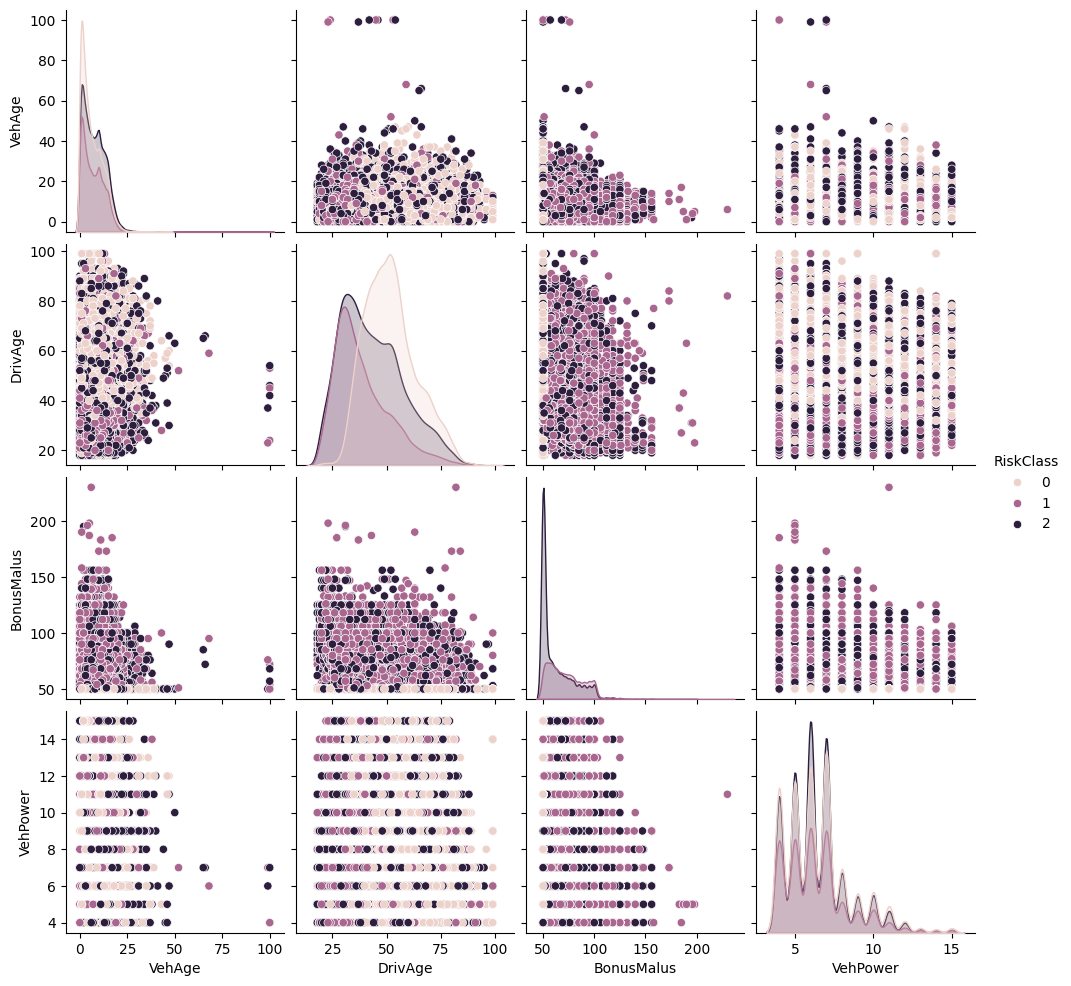

,VehAge,DrivAge,BonusMalus,VehPower,Area,VehGas,RiskClass
0,17,53,64,5,E,Diesel,1
1,2,27,64,5,E,Diesel,1
2,11,67,50,7,E,Regular,0
3,8,28,60,5,B,Diesel,2
4,1,38,50,11,A,Regular,2
...,...,...,...,...,...,...,...
99995,11,37,56,5,C,Diesel,2
99996,13,58,50,6,E,Diesel,0
99997,1,49,50,5,E,Diesel,0
99998,9,36,54,9,D,Regular,1


In [113]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# Définition des variables de caractéristiques et de la cible:
X = claims_data[['VehAge', 'DrivAge', 'BonusMalus', 'VehPower', 'Area', 'VehGas']] # X contient les caractéristiques observables des données d'assurance.
y = claims_data['ClaimNb'] # y est la variable cible, ici le nombre de réclamations (ClaimNb)

# Définition des caractéristiques catégorielles et numériques:
categorical_features = ['Area', 'VehGas']
numerical_features = ['VehAge', 'DrivAge', 'BonusMalus', 'VehPower']

# Création d'un pipeline de prétraitement: 
# ColumnTransformer applique StandardScaler aux caractéristiques numériques et OneHotEncoder aux caractéristiques catégorielles:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Les transformations sont appliquées aux données d'entrée X pour obtenir X prétraité:
X_preprocessed = preprocessor.fit_transform(X)

# Applique un modèle de mélange gaussien avec 3 composantes, pour identifier les classes de risque latentes: 
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_preprocessed)

# Les classes de risque latentes sont prédites et ajoutées aux données d'origine sous la colonne 'RiskClass':
claims_data['RiskClass'] = gmm.predict(X_preprocessed)

# Visualisation des classes de risque prédites:
sns.pairplot(claims_data, hue='RiskClass', vars=['VehAge', 'DrivAge', 'BonusMalus', 'VehPower'])
plt.show()

claims_data[['VehAge', 'DrivAge', 'BonusMalus', 'VehPower', 'Area', 'VehGas', 'RiskClass']]

In [126]:
# Ajouter les prédictions de cluster aux données d'origine
claims_data['RiskClass'] = gmm.predict(X_preprocessed)

# Sélectionner uniquement les colonnes numériques
numeric_columns = claims_data.select_dtypes(include=[np.number]).columns

# Calculer les statistiques descriptives pour chaque cluster en utilisant uniquement les colonnes numériques
cluster_summary = claims_data.groupby('RiskClass')[numeric_columns].describe()

cluster_summary

IDpol                                                          \
             count          mean           std   min        25%        50%   
RiskClass                                                                    
0          38680.0  2.680569e+06  1.659145e+06  15.0  1171639.0  2280714.5   
1          24020.0  2.706268e+06  1.653954e+06  30.0  1190536.5  2276423.0   
2          37300.0  2.495565e+06  1.612593e+06  42.0  1122931.5  2228020.5   

                                  ClaimNb            ... ClaimAmount  \
                  75%        max    count      mean  ...         75%   
RiskClass                                            ...               
0          4074798.75  6114324.0  38680.0  0.032653  ...         0.0   
1          4048601.75  6114321.0  24020.0  0.051998  ...         0.0   
2          4014976.25  6114291.0  37300.0  0.037265  ...         0.0   

                    RiskClass                                     
                max     count mean  std  min  25%  50%  75%  max  
RiskClass                                                         
0          200000.0   38680.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1          200000.0   24020.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
2           91054.1   37300.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  

[3 rows x 80 columns]

In [127]:
# Extraire les statistiques descriptives pour les montants des réclamations
claim_amount_stats = cluster_summary['ClaimAmount'][['mean', 'std', 'max']]

# Afficher les statistiques pour chaque classe de risque
print(claim_amount_stats)

# Identifier la classe de risque la plus risquée
most_risky_class = claim_amount_stats['mean'].idxmax()
print(f"La classe de risque la plus risquée est : {most_risky_class}")

                 mean          std       max
RiskClass                                   
0           77.991224  1895.589358  200000.0
1          106.692965  1797.844786  200000.0
2           55.778099   694.577535   91054.1
La classe de risque la plus risquée est : 1
